# Model Test

This notebook tests the model on artifical data of the following form:
1. Two modalities - "normal" (representing normalized abundance) and "beta" (representing polarization), each with 50 features
2. The "normal" modality has two subpopulations with different means, and well separated distributions (meant to simulate different cell types)
3. The "beta" modality has two subpopulations with the same mean (0.5) but different distributions - one is actually beta while the other
is just a constant 0.5 (meant to represent polarized / unpolarized cells)
4. The two groups are mixed to create 4 sample types altogether. Also, the fraction of cells with constant "beta" modality is 0.25 and not 0.5 to make things slightly more interesting.

The models work as expected, with the following observations:
1. The "normal" modality is modelled excellently with a normal distribution
2. The "beta" modality is modelled *better* with a normal distribution (after standardization) than with a beta distribution. The latter fails to differentiate between the constant and distributed groups (even when the model predicts a mixture distribution with a constant distribution). This is an observation first noticed on actual data and extracted to this test notebook.
3. When "beta" is modelled with a normal distribution, the latent space is perfectly separated into 4, and the errors of the "beta" modality reconstructions perfectly follow the distributional properties.
4. Note the difference between a full (stochastic) reconstruction and reconstruction *means*. The latter has lower MSE by definition, because the former has added variance. Hence the error of the model when using a full reconstruction is higher than the mean baseline (on a unimodal distribution). However, only when using a full reconstruction can one compare the reconstruction distribution to the ground truth.
5. The difference here between the weighted separate latents and the shared encoder is negligible.
6. PCA can tell the difference between the normal distributions but not the beta (probably since they have the same mean and close values)

In [1]:
import anndata
import pixelator
import torch
import scvi
import scipy
# from scvi import autotune

import seaborn as sns
import scanpy as sc
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

from scib_metrics.benchmark import Benchmarker, BioConservation, BatchCorrection

# import ray
# from ray import tune


from PixelGen.pxl_utils import train_model, get_model_latents
from PixelGen.scvi_utils import plot_losses, pca_neighbors_umap, calc_PCA

from pixelator.plot import molecule_rank_plot, cell_count_plot, scatter_umi_per_upia_vs_tau
from pixelator.statistics import clr_transformation
from pixelator.analysis.normalization import dsb_normalize


from sklearn.preprocessing import StandardScaler, MinMaxScaler 


import tempfile

from scvi import REGISTRY_KEYS
from scvi.module.base import (
    BaseModuleClass,
    LossOutput,
    PyroBaseModuleClass,
    auto_move_data,
)
from torch.distributions import NegativeBinomial, Normal, Poisson, MixtureSameFamily, Beta
from torch.distributions import kl_divergence as kl

from PixelGen.multimodalvi import MultiModalSCVI
from PixelGen.multimodalvae import MultiModalVAE, AggMethod, D
from PixelGen.enums import AggMethod, D
from PixelGen.metrics import MultiModalVIMetrics

# from cytovi import CytoVI

print(torch.cuda.is_available())


scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)
sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"
%load_ext autoreload
%autoreload 2

Seed set to 0


True
Last run with scvi-tools version: 1.2.2.post2


In [2]:
rng = np.random.default_rng(seed=0)

n_obs = 1000
constant_beta_frac = 0.25
n_constant_beta = int(n_obs*constant_beta_frac)
n_real_beta = n_obs - n_constant_beta

n_normal_1 = 500
n_normal_2 = n_obs - n_normal_1

beta_1 = rng.beta(a=50, b=50, size=(n_real_beta, 50))
beta_2 = np.ones((n_constant_beta,50))*0.5
normal_1 = rng.normal(loc=1, scale=0.3, size=(n_normal_1, 50))
normal_2 = rng.normal(loc=-1, scale=0.6, size=(n_normal_2, 50))

beta = np.concatenate((beta_1, beta_2), axis=0)
normal = np.concatenate((normal_1, normal_2), axis=0)

obs_beta_group = np.array(['beta_1']*n_real_beta + ['beta_2']*n_constant_beta)
obs_normal_group = np.array(['normal_1']*n_normal_1 + ['normal_2']*n_normal_2)

beta_perm = rng.permutation(n_obs, axis=0)
normal_perm = rng.permutation(n_obs, axis=0)

beta = beta[beta_perm]
obs_beta_group = obs_beta_group[beta_perm]
normal = normal[normal_perm]
obs_normal_group = obs_normal_group[normal_perm]

obs_names = [f'obs_{i}' for i in range(n_obs)]

normal_features = [f'{i}_normal' for i in range(50)]
beta_features = [f'{i}_beta' for i in range(50)]

normal_df = pd.DataFrame(normal, columns=normal_features, index=obs_names)
beta_df = pd.DataFrame(beta, columns=beta_features, index=obs_names)

test_adata = anndata.AnnData(
    X = normal_df,
    obs= pd.DataFrame({'normal_group': obs_normal_group, 'beta_group': obs_beta_group}, index=obs_names),
    obsm={
        'beta': beta_df,
        'beta_std': (beta_df - beta_df.mean(axis=0)) / beta_df.std(axis=0),
    },
    layers={
        'normal': normal_df,
    }
)

sample_map = {
    ('beta_1', 'normal_1'): '1', ('beta_1', 'normal_2'): '2', ('beta_2', 'normal_1'): '3', ('beta_2', 'normal_2'): '4',
}

test_adata.obs['sample'] = test_adata.obs[['beta_group', 'normal_group',]].apply(tuple, axis=1).map(sample_map)
test_adata.obs

normal_group beta_group sample
obs_0       normal_1     beta_1      1
obs_1       normal_1     beta_1      1
obs_2       normal_2     beta_1      2
obs_3       normal_1     beta_1      1
obs_4       normal_1     beta_1      1
...              ...        ...    ...
obs_995     normal_2     beta_1      2
obs_996     normal_1     beta_1      1
obs_997     normal_1     beta_1      1
obs_998     normal_1     beta_1      1
obs_999     normal_1     beta_2      3

[1000 rows x 3 columns]

<Axes: xlabel='0_beta_std_obs', ylabel='Count'>

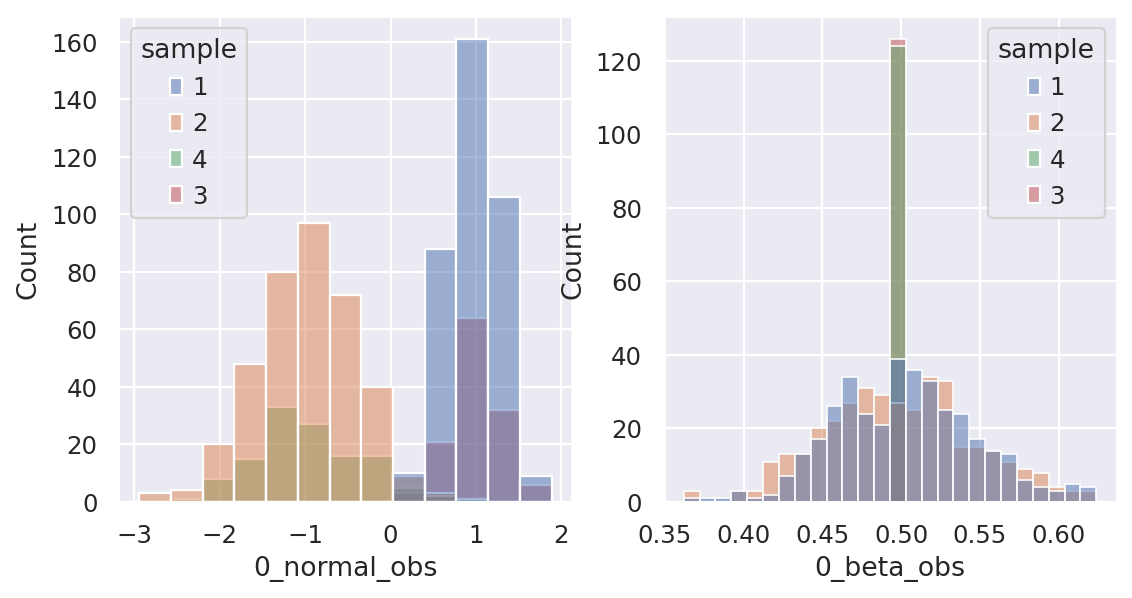

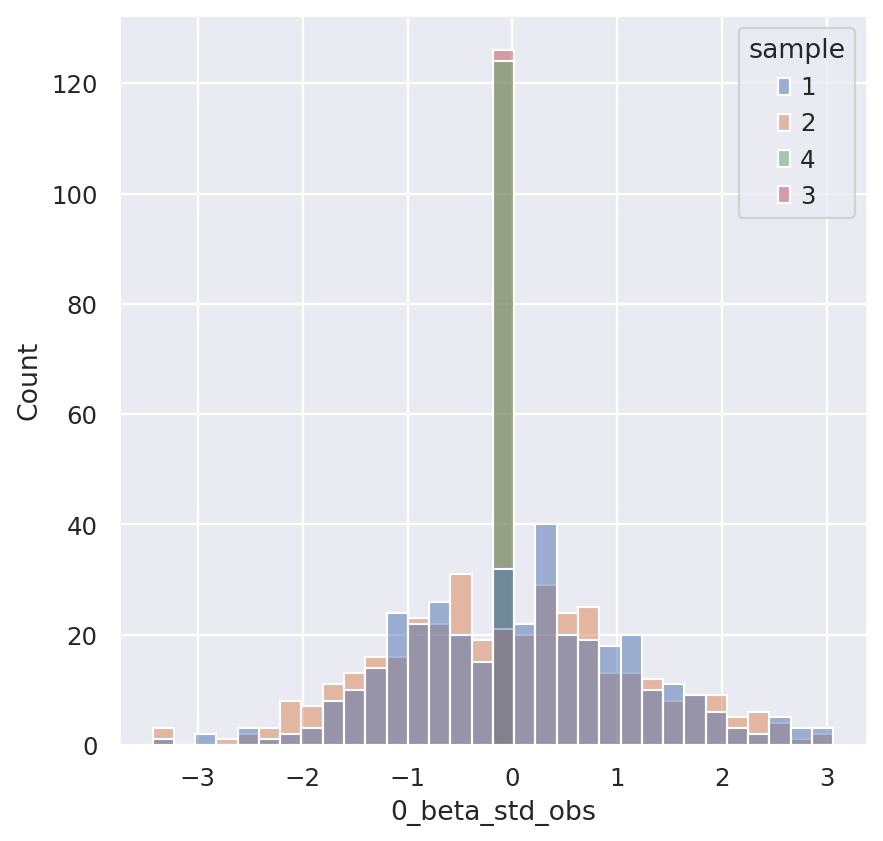

In [3]:
test_adata.obs['0_normal_obs'] = test_adata.to_df()['0_normal']
test_adata.obs['0_beta_obs'] = test_adata.obsm['beta']['0_beta']
test_adata.obs['0_beta_std_obs'] = test_adata.obsm['beta_std']['0_beta']

fig, ax = plt.subplots(1, 2, figsize=(8,4))
sns.histplot(test_adata.obs, x='0_normal_obs', hue='sample', ax=ax[0])
sns.histplot(test_adata.obs, x='0_beta_obs', hue='sample', ax=ax[1], binwidth=0.01, stat='count')

sns.histplot(test_adata.obs, x='0_beta_std_obs', hue='sample', ax=plt.subplots(1)[1])

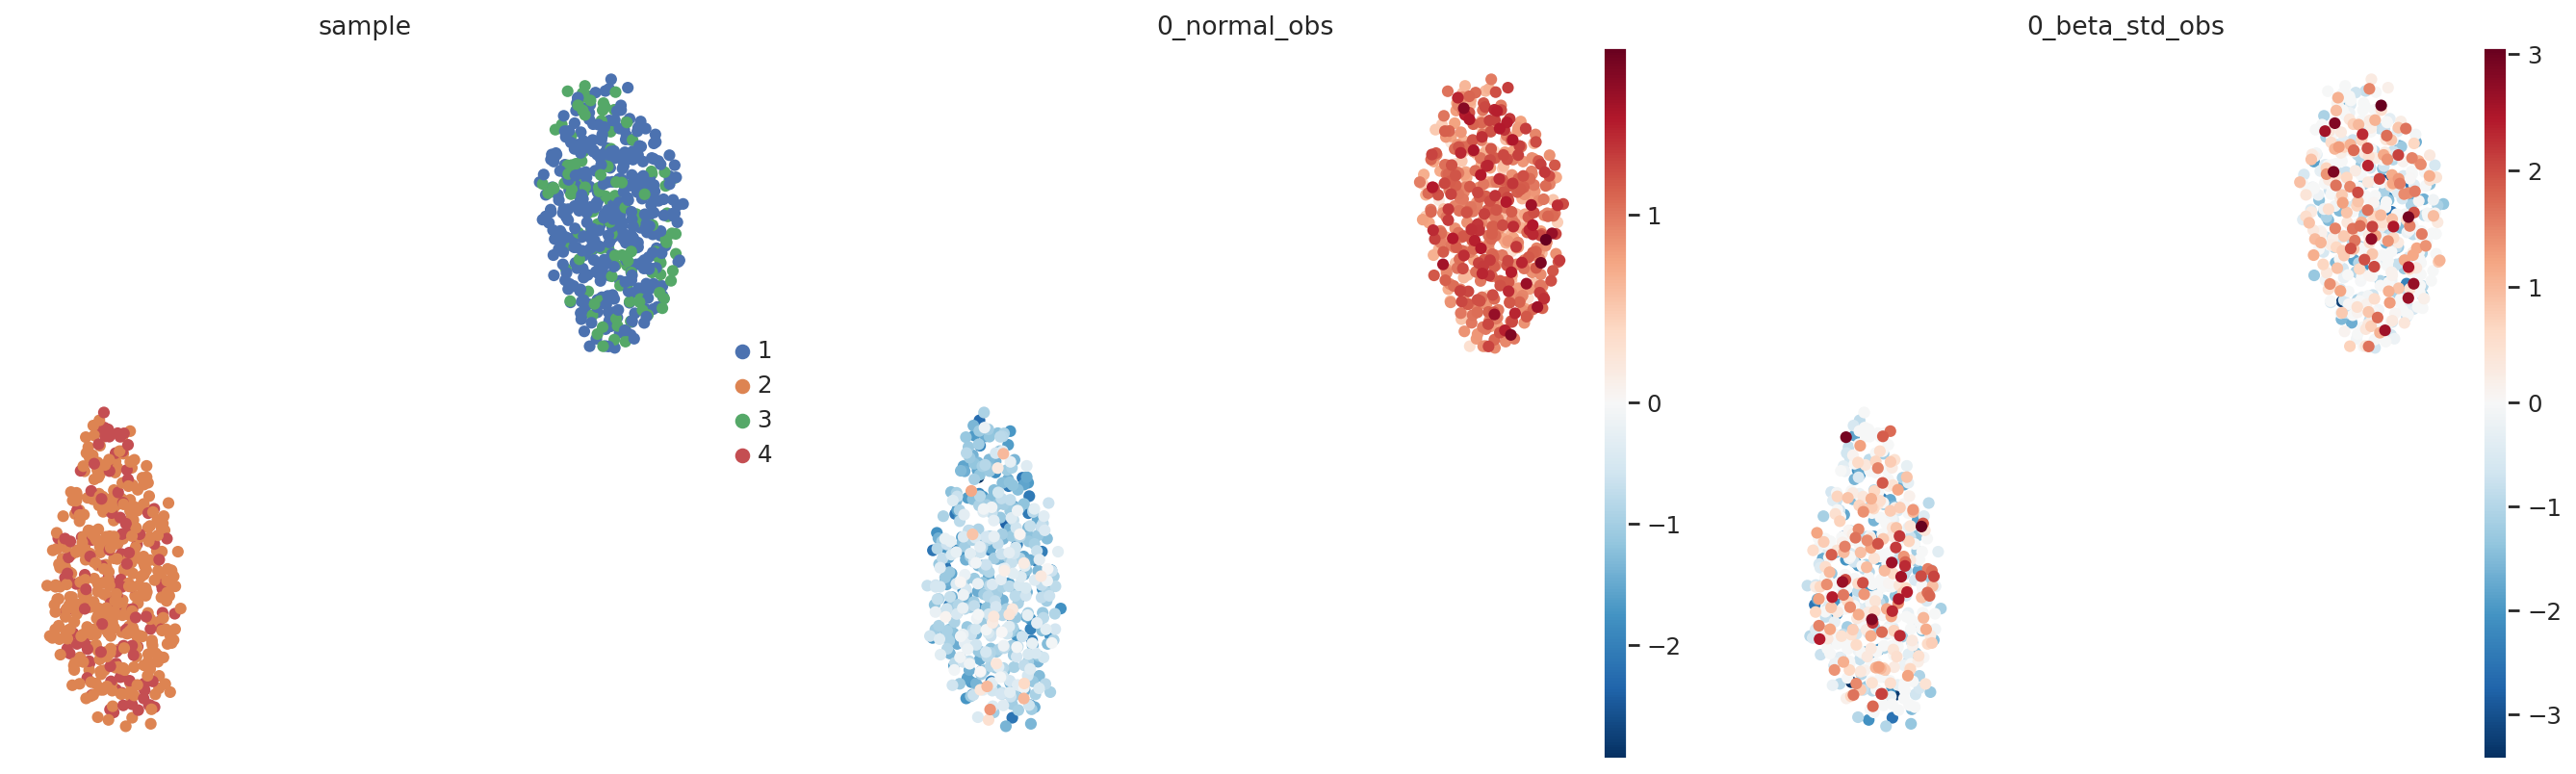

In [4]:
test_adata.obsm['concat'] = pd.concat(
    (test_adata.to_df('normal'), test_adata.obsm['beta_std']),
    axis=1
)
calc_PCA(test_adata, key_added='concat', rep='concat',)
fig = pca_neighbors_umap(test_adata, latent_name='concat_pca', 
                   umap_pl_kwargs=dict(color=['sample', '0_normal_obs', '0_beta_std_obs'], vcenter=0, cmap='RdBu_r'))

INFO     Using column names from columns of adata.obsm['beta_std']                                                 


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/projects/nyosef/eitangr/miniconda3/envs/pixelgen-scvi/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/home/projects/nyosef/eitangr/miniconda3/envs/pixelgen-scvi/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
/home/projects/nyosef/eitangr/miniconda3/envs/pixelgen-scvi/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' d

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 200 records. Best score: 46.470. Signaling Trainer to stop.


/home/projects/nyosef/eitangr/miniconda3/envs/pixelgen-scvi/lib/python3.10/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


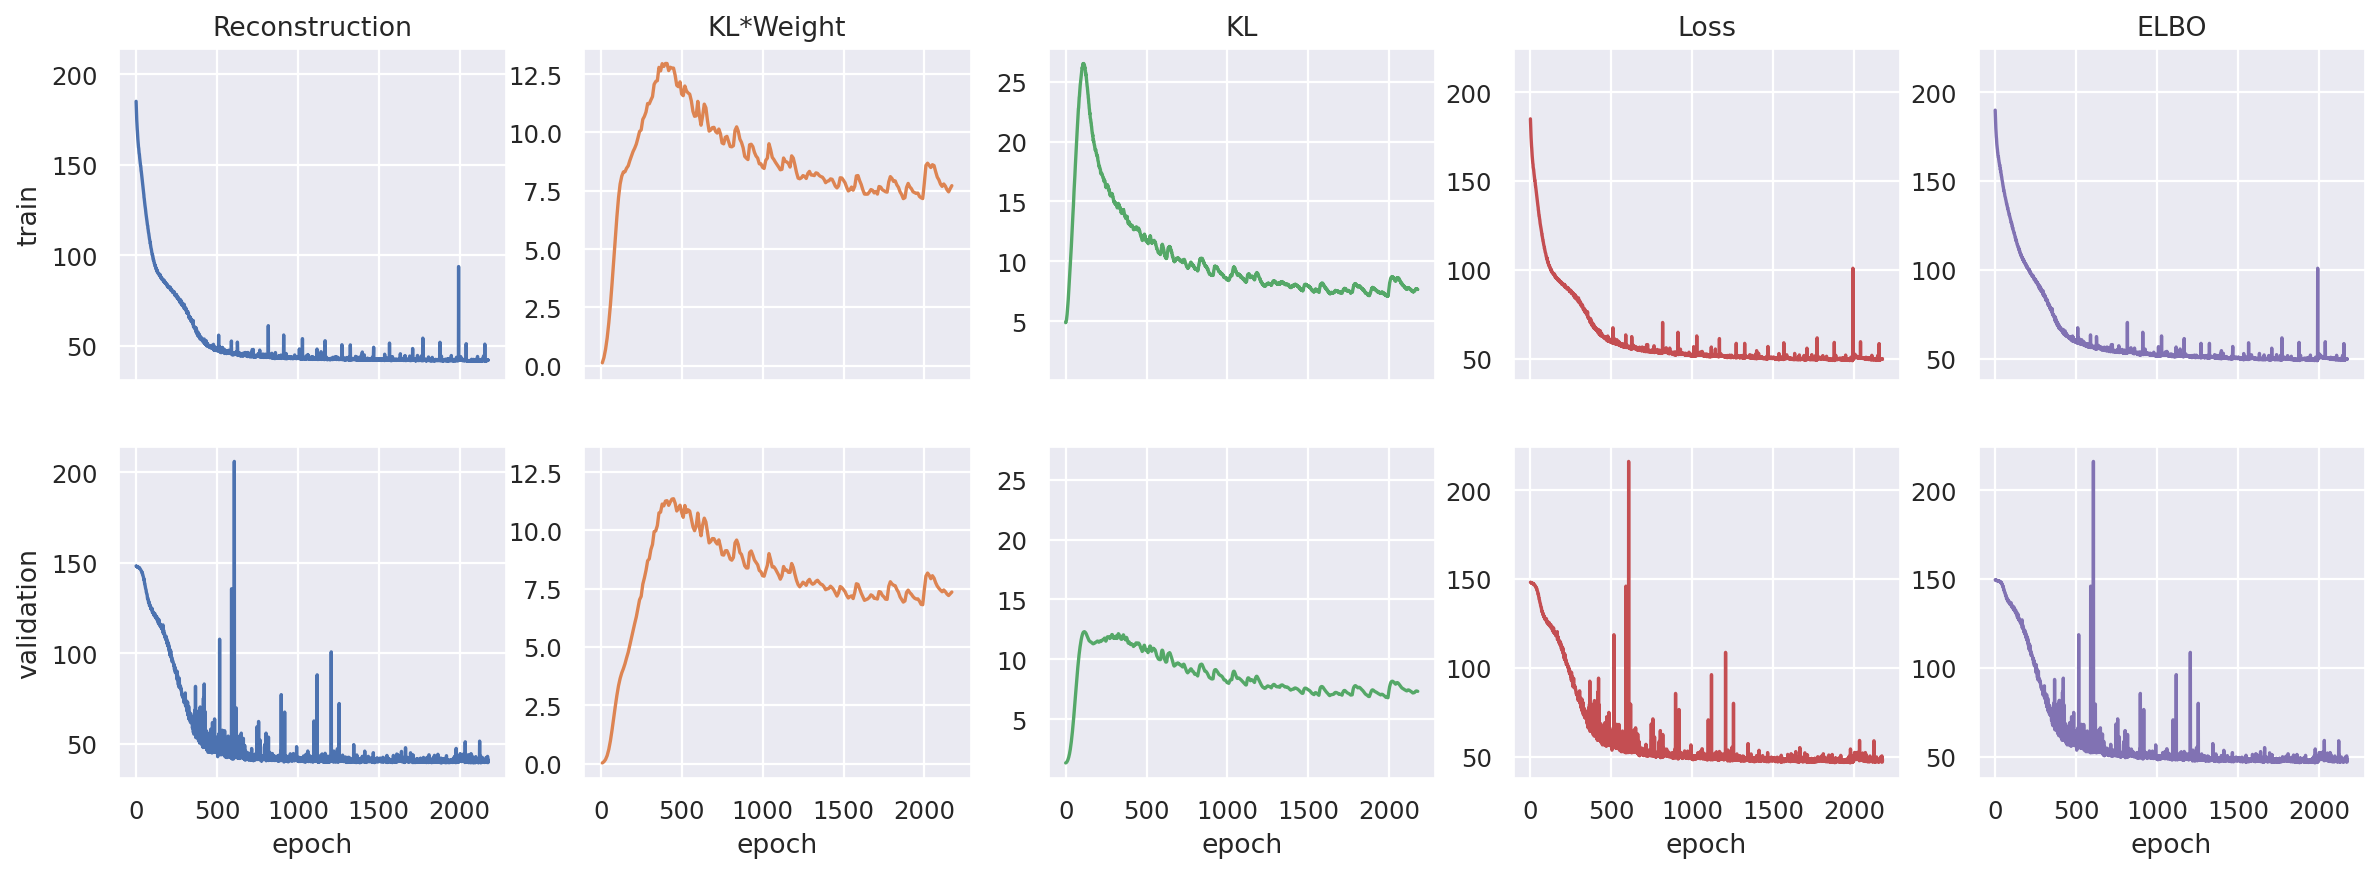

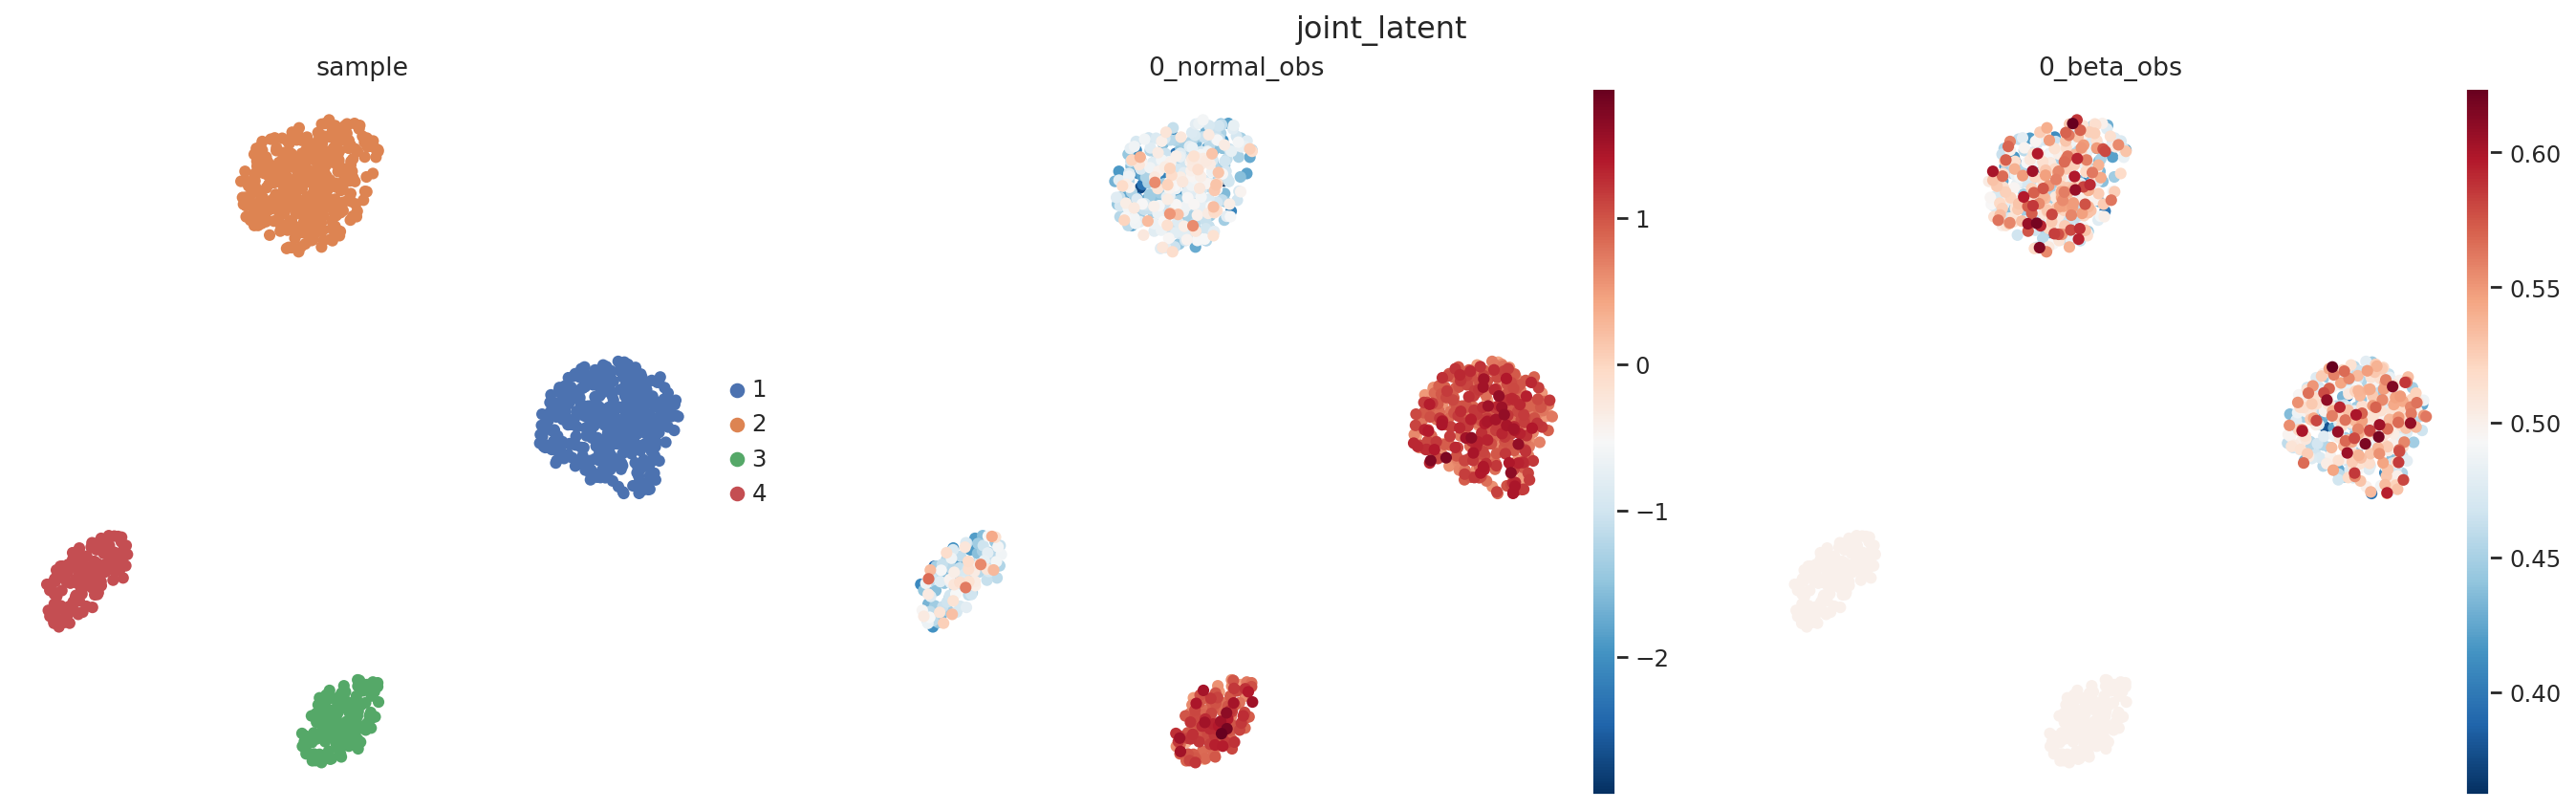

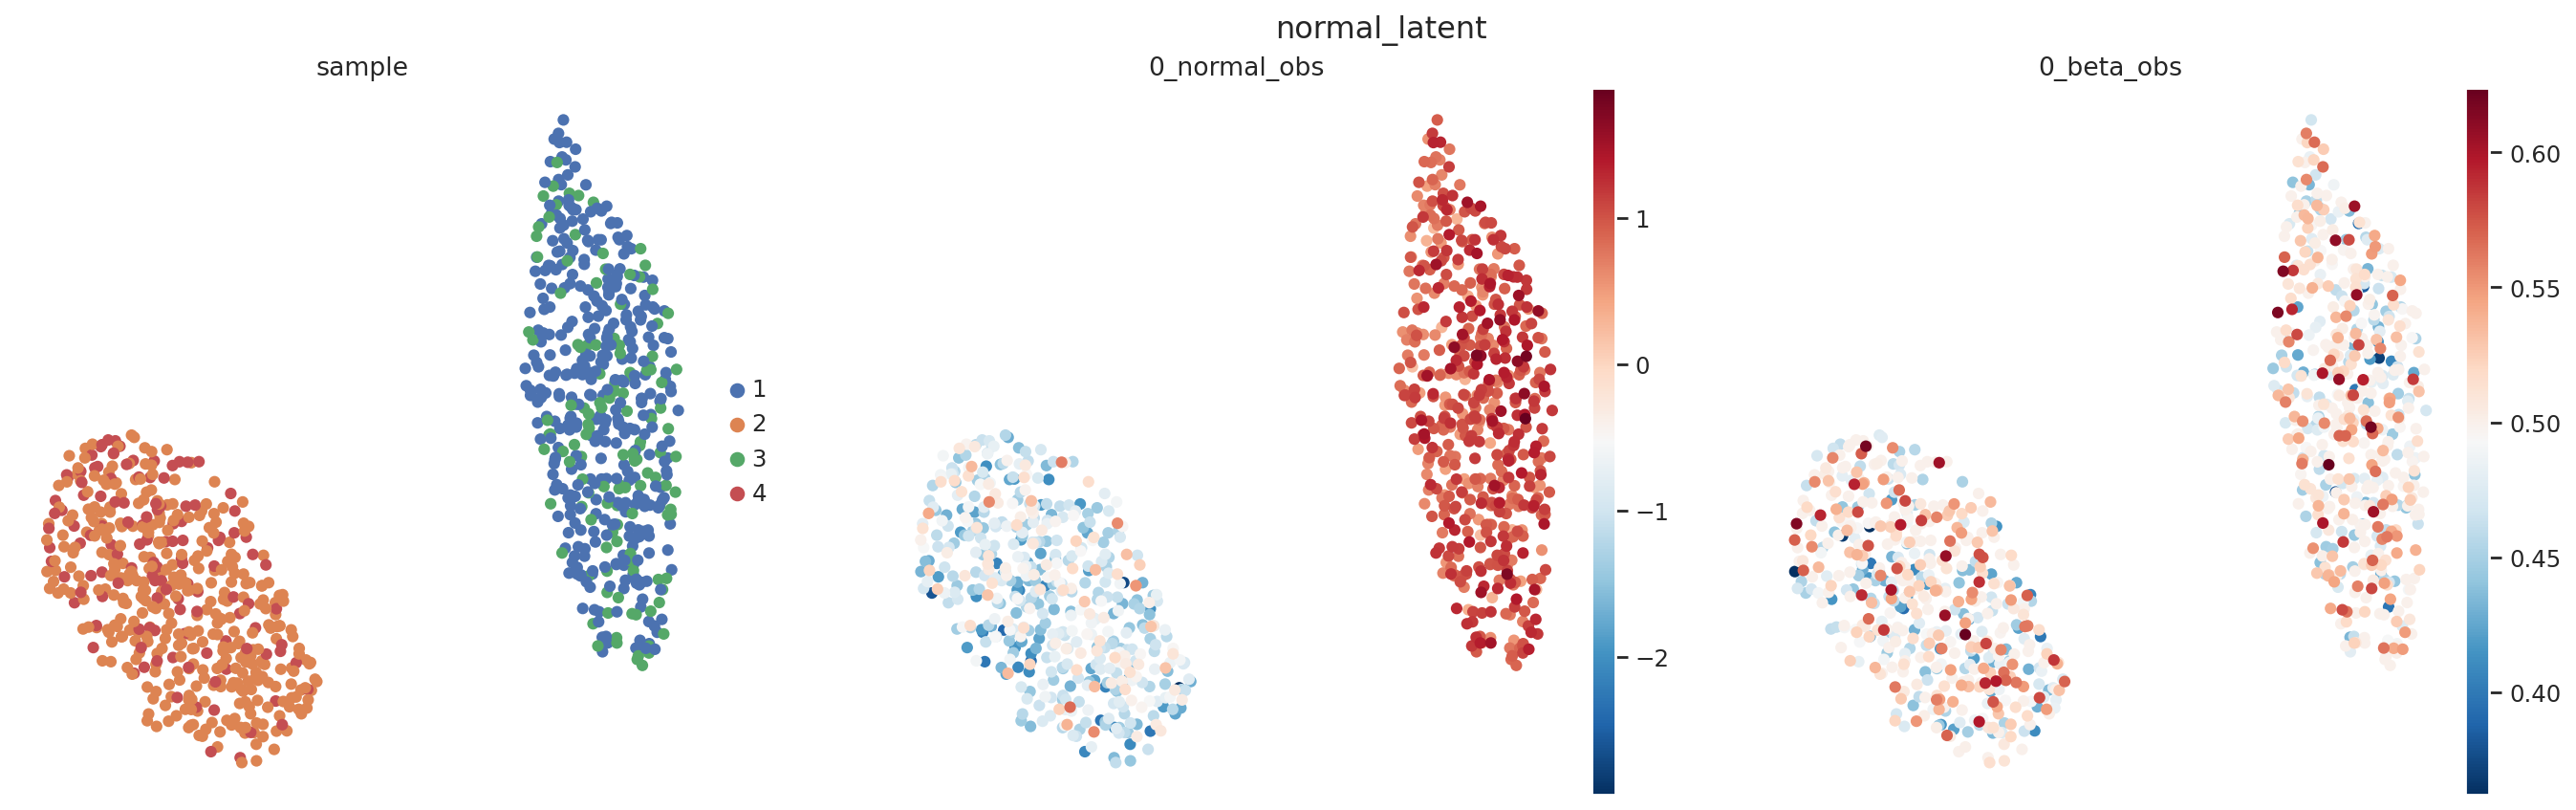

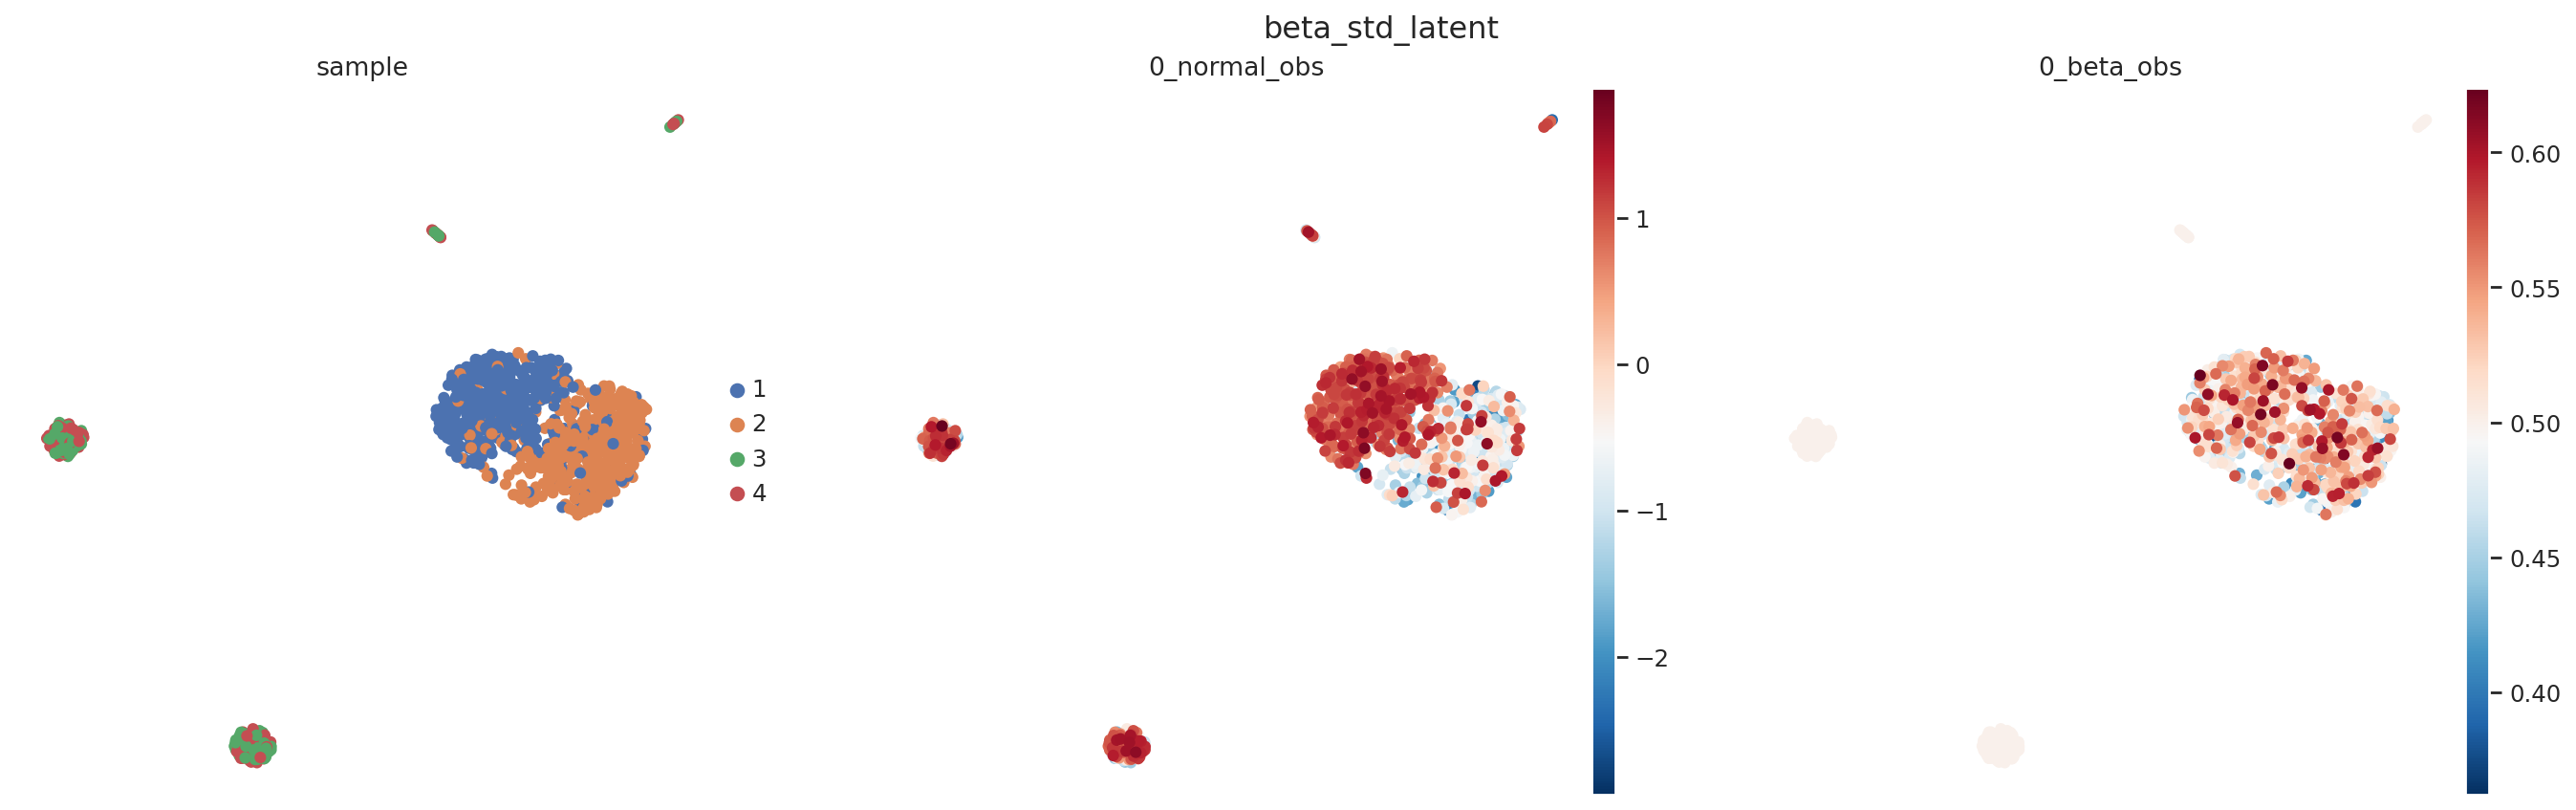

In [5]:
model_cls = MultiModalSCVI
setup_kwargs = dict(layer='normal', extra_modality_keys=['beta_std'], n_modalities=2, batch_key=None, )
model_kwargs = dict(n_latent=20, n_hidden=128, n_layers=2, dropout_rate=0.1, distrs=[D.Normal, D.Normal], 
                        joint_kl=False, unimodal_kl=True,
                        decoder_kwargs=dict(decoder_param_eps=1e-2, decoder_activation='exp'),
                    )
train_kwargs = dict(train_size=0.8, check_val_every_n_epoch=1, early_stopping=True, early_stopping_patience=200, batch_size=2000,
                    max_epochs=10000, enable_checkpointing=True, plan_kwargs=dict(lr=3e-4, optimizer='Adam', n_epochs_kl_warmup=400))
test_model = train_model(test_adata, model_cls=model_cls, setup_kwargs=setup_kwargs, model_kwargs=model_kwargs, train_kwargs=train_kwargs)

modalities_latent_names=[(s,f'{s}_latent') for s in ('joint', 'normal', setup_kwargs['extra_modality_keys'][0])]
get_model_latents(test_adata, test_model, modalities_latent_names=modalities_latent_names)
for key, name in modalities_latent_names:
    title = name
    fig = pca_neighbors_umap(test_adata, name, umap_pl_kwargs=dict(color=['sample', '0_normal_obs', '0_beta_obs'], cmap='RdBu_r')).suptitle(title)

INFO     Using column names from columns of adata.obsm['beta_std']                                                 


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/projects/nyosef/eitangr/miniconda3/envs/pixelgen-scvi/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/home/projects/nyosef/eitangr/miniconda3/envs/pixelgen-scvi/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
/home/projects/nyosef/eitangr/miniconda3/envs/pixelgen-scvi/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' d

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 200 records. Best score: 46.510. Signaling Trainer to stop.


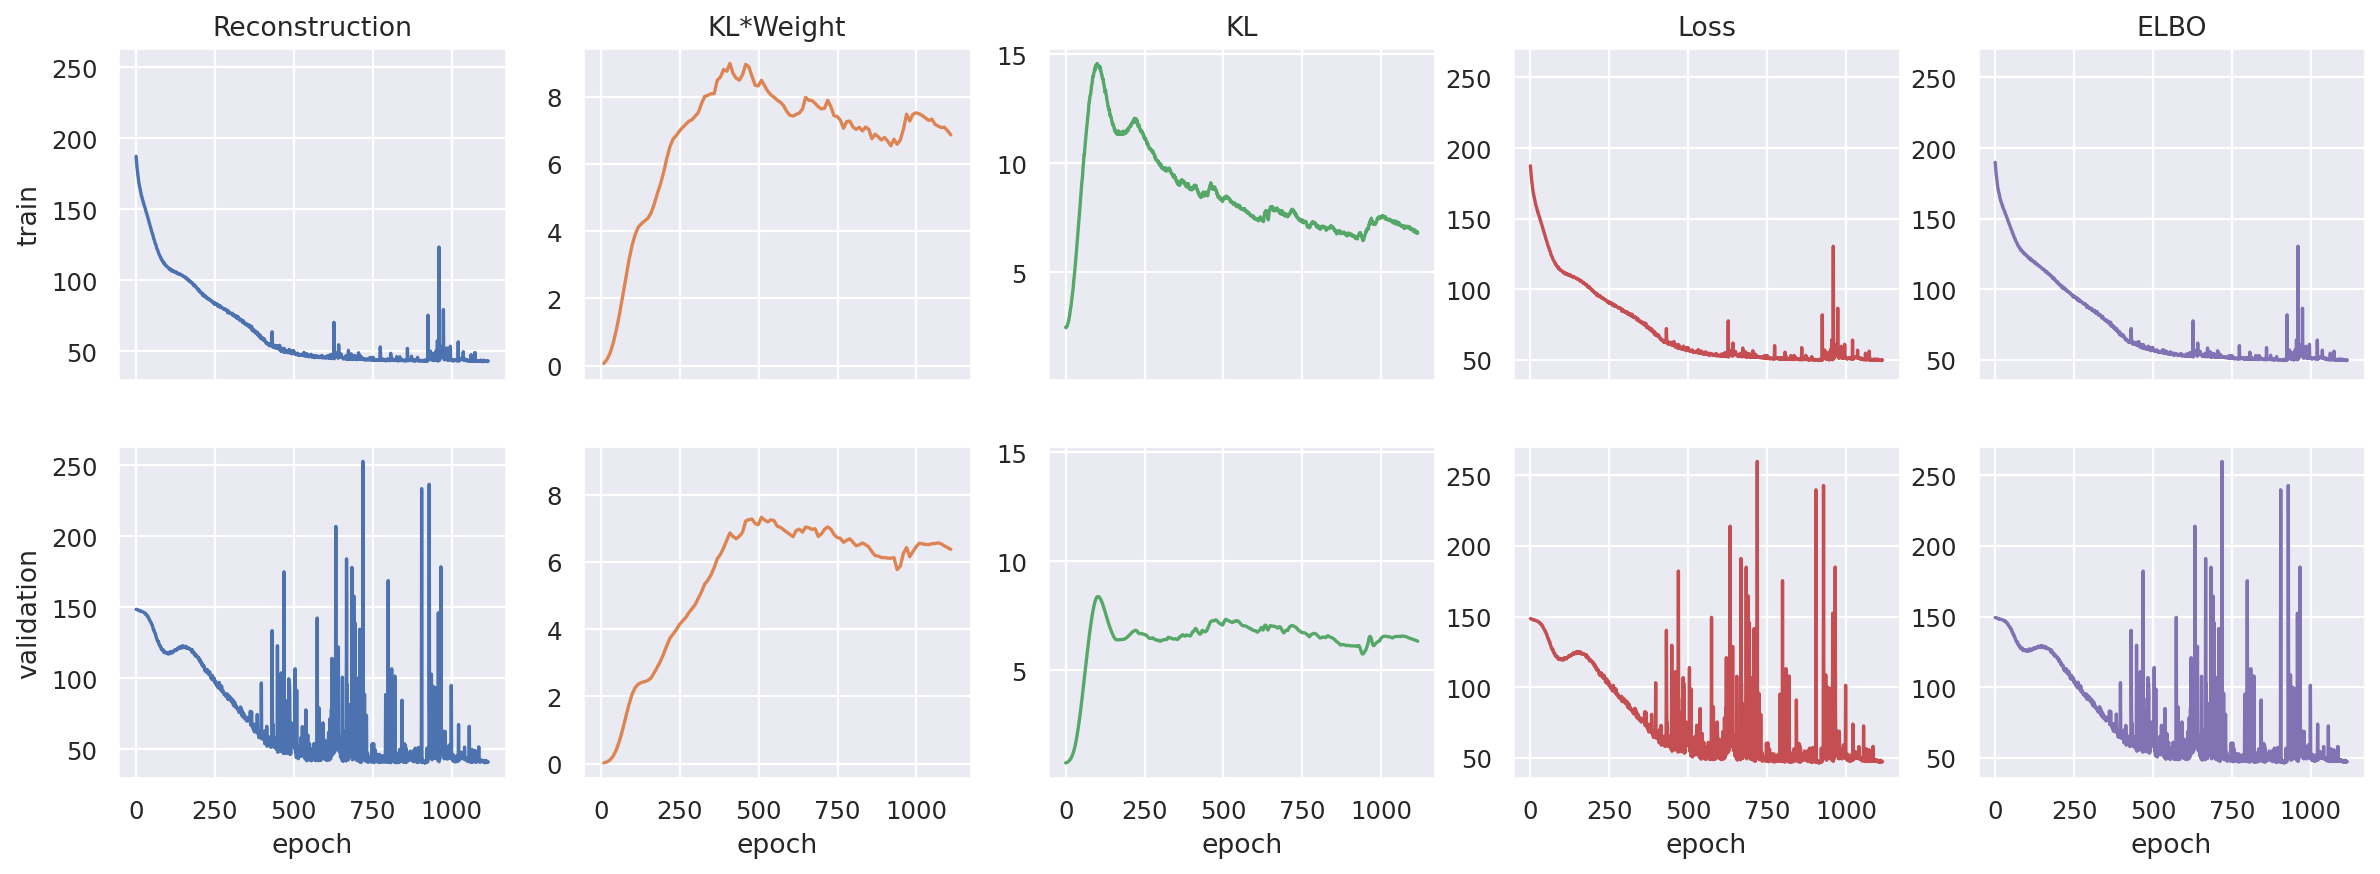

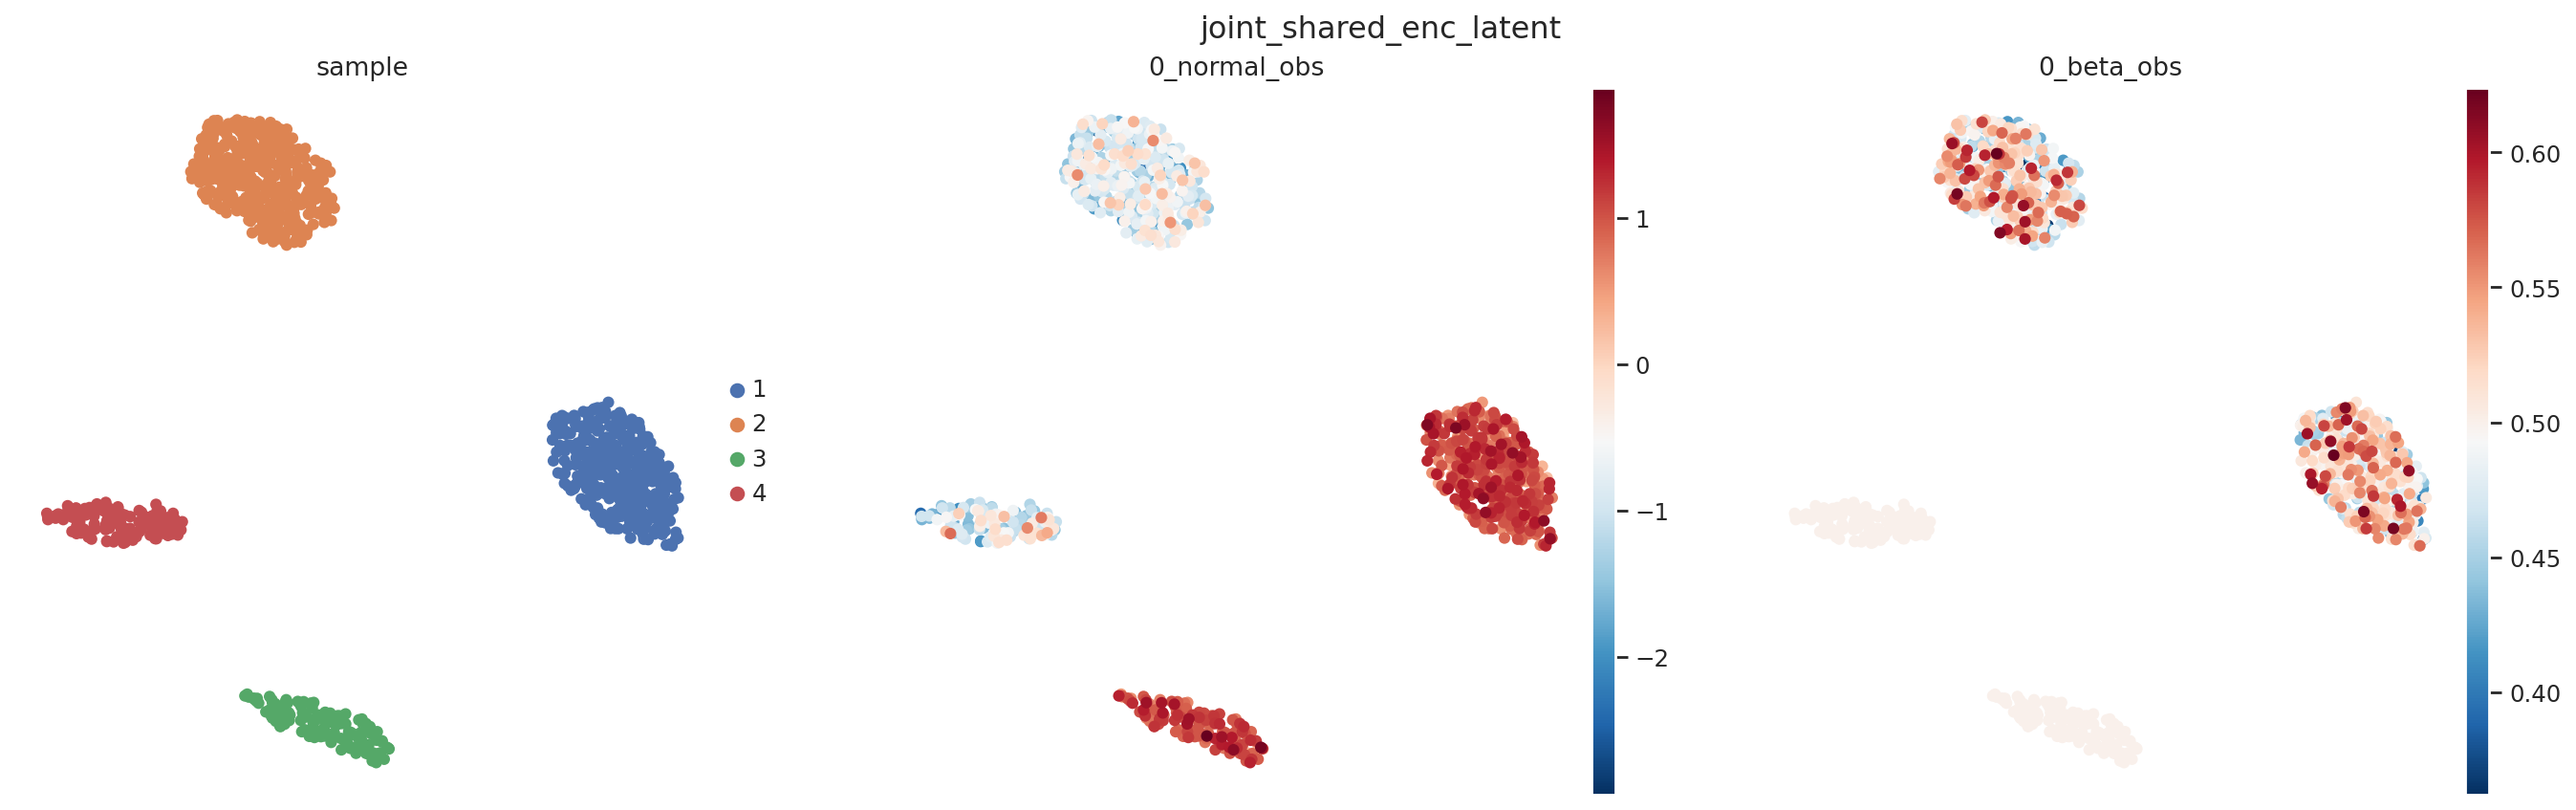

In [6]:
model_cls = MultiModalSCVI
setup_kwargs = dict(layer='normal', extra_modality_keys=['beta_std'], n_modalities=2, batch_key=None, )
model_kwargs = dict(n_latent=20, n_hidden=128, n_layers=2, dropout_rate=0.1, distrs=[D.Normal, D.Normal], 
                        agg_method=AggMethod.SHARED_ENCODER,
                        joint_kl=True, unimodal_kl=False,
                        decoder_kwargs=dict(decoder_param_eps=1e-2, decoder_activation='exp'),
                    )
train_kwargs = dict(train_size=0.8, check_val_every_n_epoch=1, early_stopping=True, early_stopping_patience=200, batch_size=2000,
                    max_epochs=10000, enable_checkpointing=True, plan_kwargs=dict(lr=3e-4, optimizer='Adam', n_epochs_kl_warmup=400))
test_shared_enc_model = train_model(test_adata, model_cls=model_cls, setup_kwargs=setup_kwargs, model_kwargs=model_kwargs, train_kwargs=train_kwargs)

modalities_latent_names=[(s,f'{s}_shared_enc_latent') for s in ('joint', )]
get_model_latents(test_adata, test_shared_enc_model, modalities_latent_names=modalities_latent_names)
for key, name in modalities_latent_names:
    title = name
    fig = pca_neighbors_umap(test_adata, name, umap_pl_kwargs=dict(color=['sample', '0_normal_obs', '0_beta_obs'], cmap='RdBu_r')).suptitle(title)

INFO     Using column names from columns of adata.obsm['beta']                                                     


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/projects/nyosef/eitangr/miniconda3/envs/pixelgen-scvi/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/home/projects/nyosef/eitangr/miniconda3/envs/pixelgen-scvi/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
/home/projects/nyosef/eitangr/miniconda3/envs/pixelgen-scvi/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' d

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 200 records. Best score: -55.314. Signaling Trainer to stop.


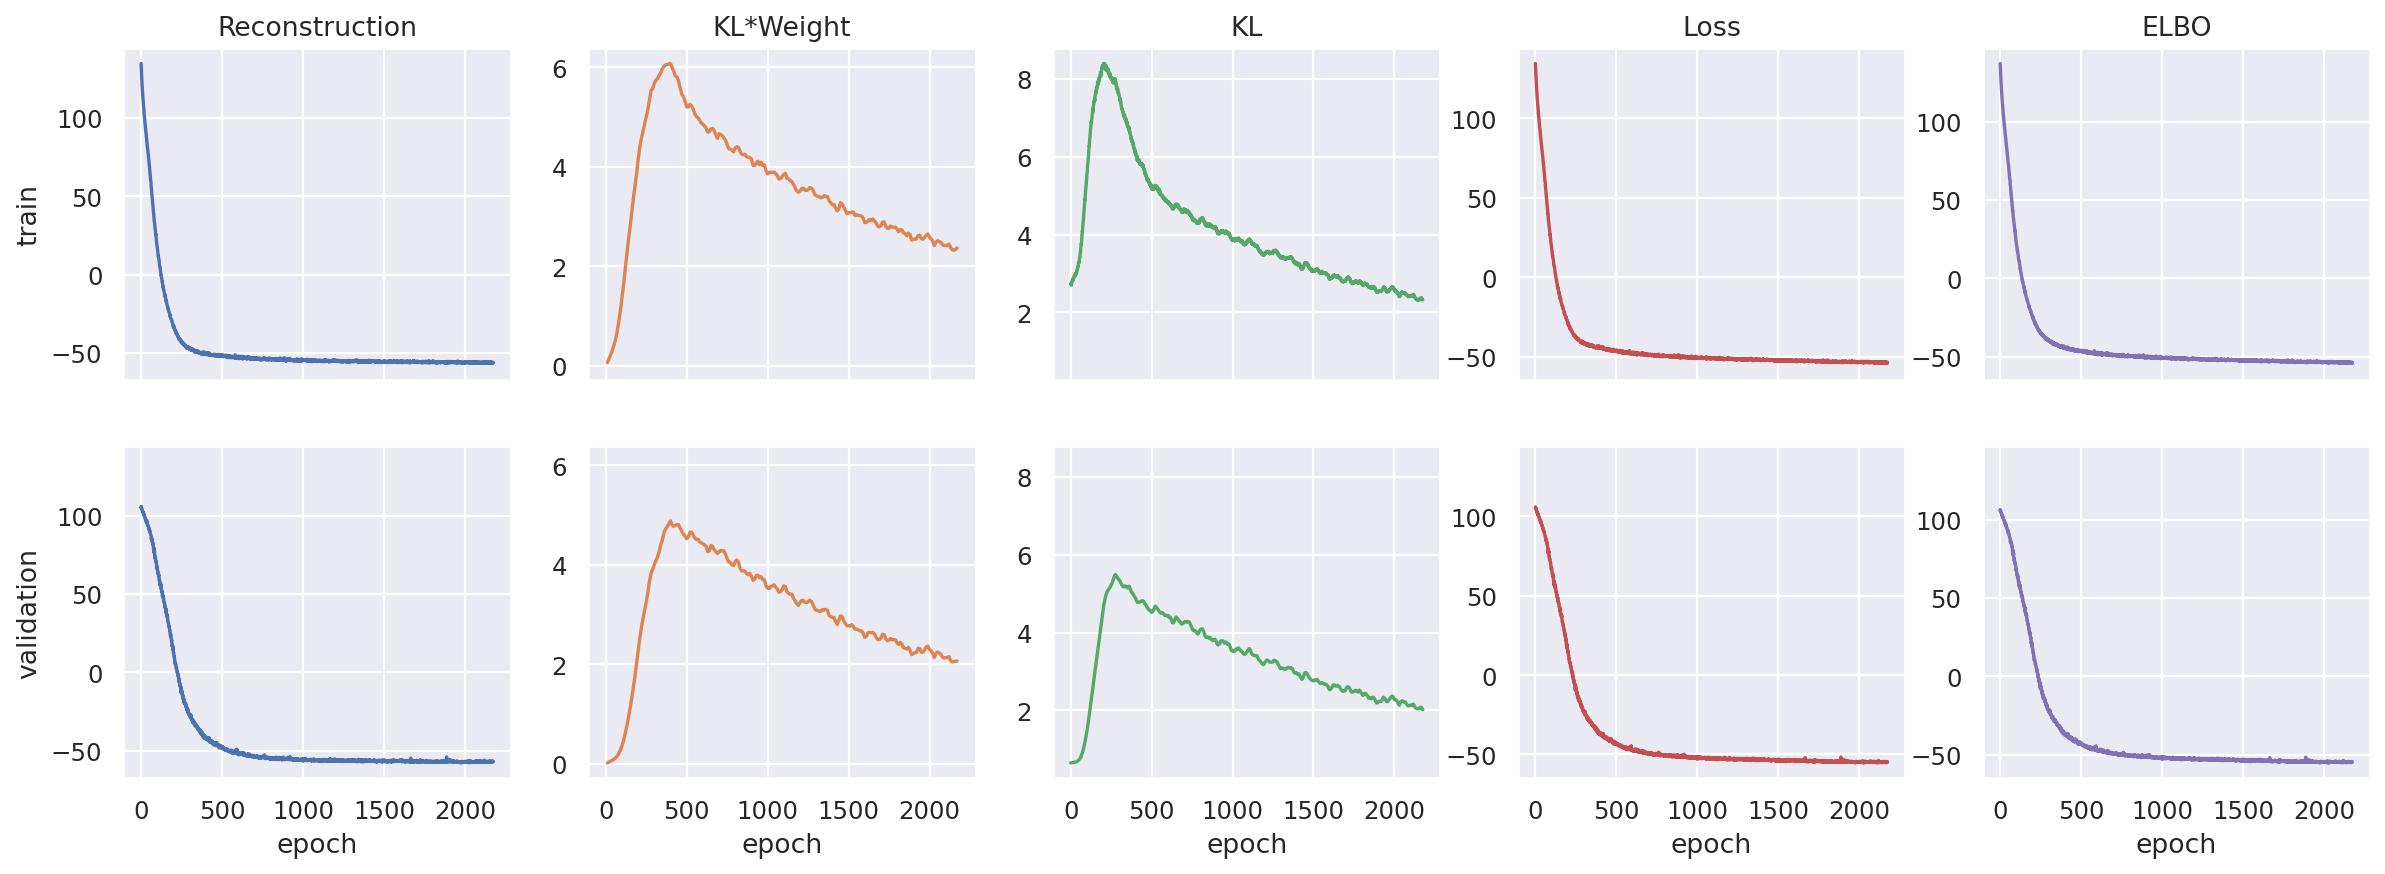

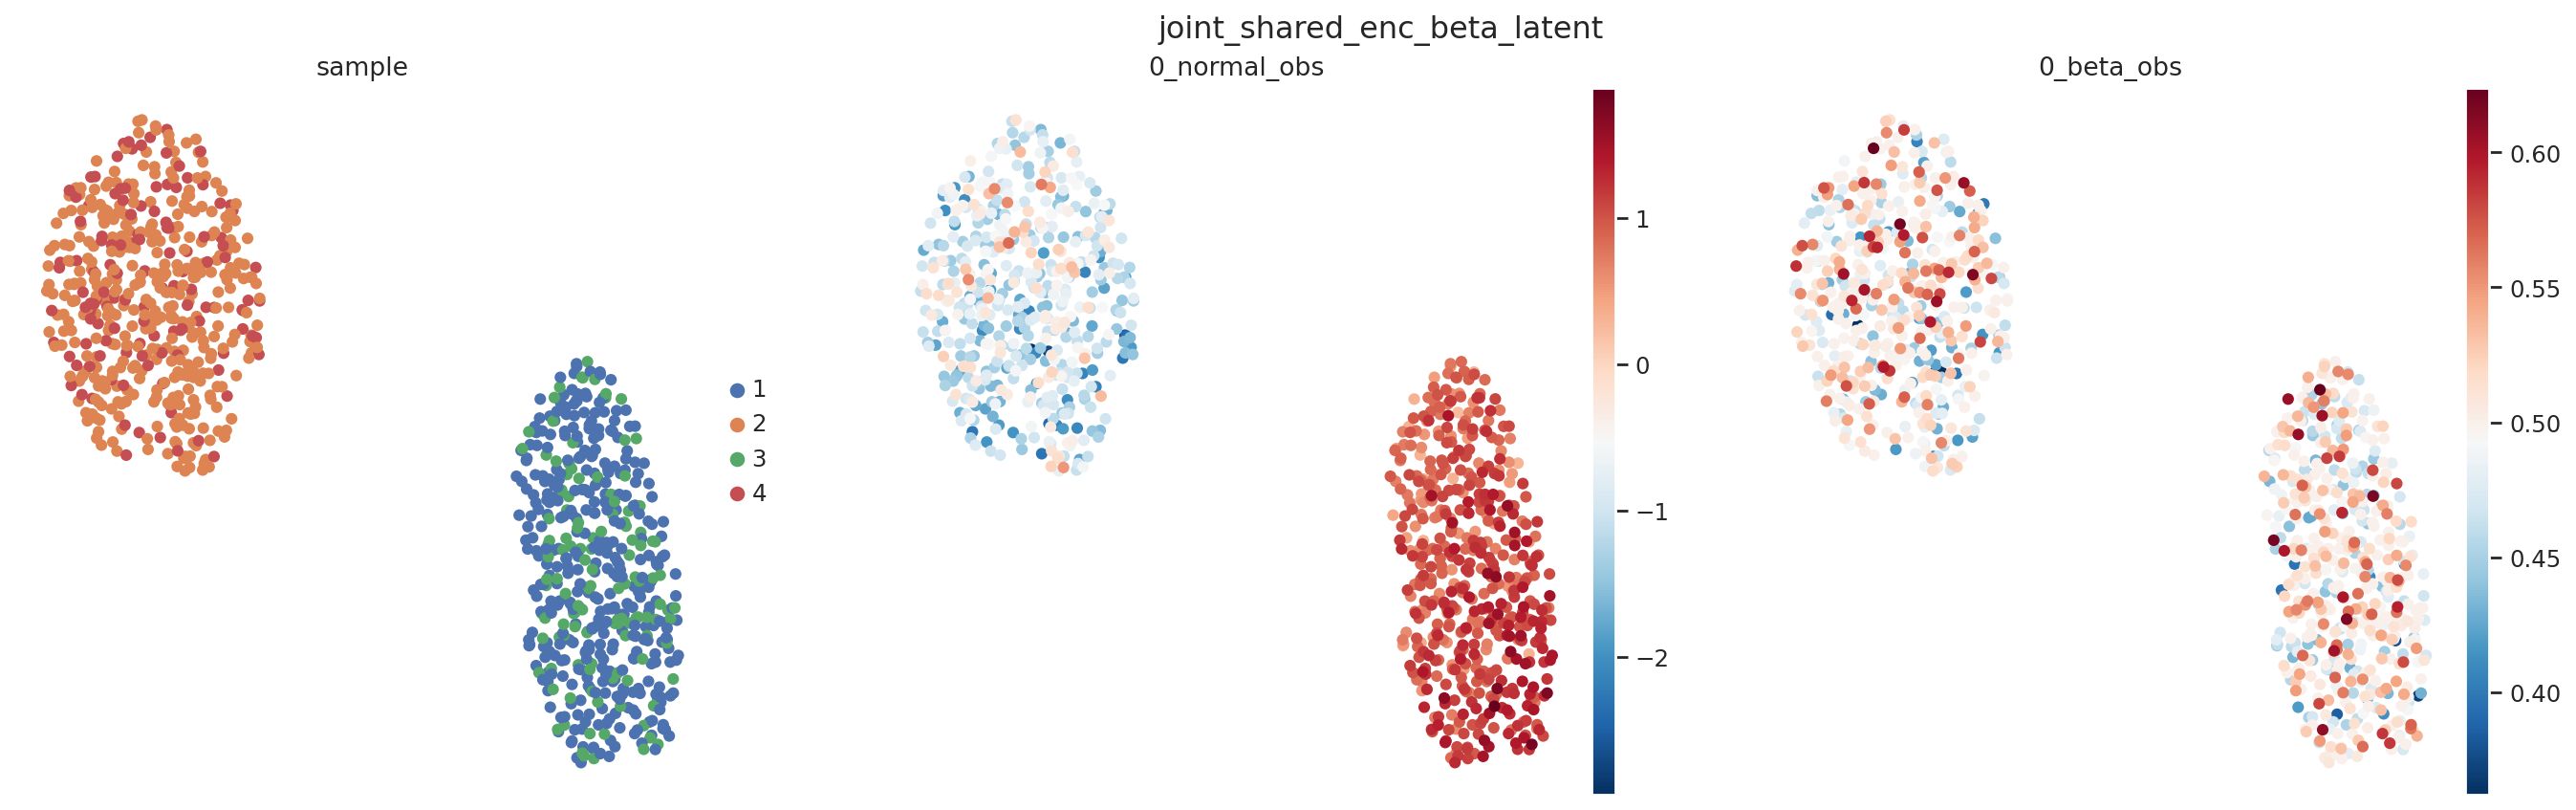

In [7]:
model_cls = MultiModalSCVI

setup_kwargs = dict(layer='normal', extra_modality_keys=['beta'], n_modalities=2, batch_key=None, )
model_kwargs = dict(n_latent=20, n_hidden=128, n_layers=2, dropout_rate=0.1, 
                        distrs=[D.Normal, D.Beta], 
                        agg_method=AggMethod.SHARED_ENCODER,
                        joint_kl=True, unimodal_kl=False,
                        allow_beta_constant=True,
                        decoder_kwargs=dict(decoder_param_eps=1e-2, decoder_activation='exp'),
                    )
train_kwargs = dict(train_size=0.8, check_val_every_n_epoch=1, early_stopping=True, early_stopping_patience=200, batch_size=2000,
                    max_epochs=10000, enable_checkpointing=True, plan_kwargs=dict(lr=3e-4, optimizer='Adam', n_epochs_kl_warmup=400))
test_shared_enc_beta_model = train_model(test_adata, model_cls=model_cls, setup_kwargs=setup_kwargs, model_kwargs=model_kwargs, train_kwargs=train_kwargs)

modalities_latent_names=[(s,f'{s}_shared_enc_beta_latent') for s in ('joint', )]
get_model_latents(test_adata, test_shared_enc_beta_model, modalities_latent_names=modalities_latent_names)
for key, name in modalities_latent_names:
    title = name
    fig = pca_neighbors_umap(test_adata, name, umap_pl_kwargs=dict(color=['sample', '0_normal_obs', '0_beta_obs'], cmap='RdBu_r')).suptitle(title)

INFO     Using column names from columns of adata.obsm['beta_std']                                                 
INFO     Using column names from columns of adata.obsm['beta_std']                                                 
INFO     Using column names from columns of adata.obsm['beta_std']                                                 
INFO     Using column names from columns of adata.obsm['beta_std']                                                 


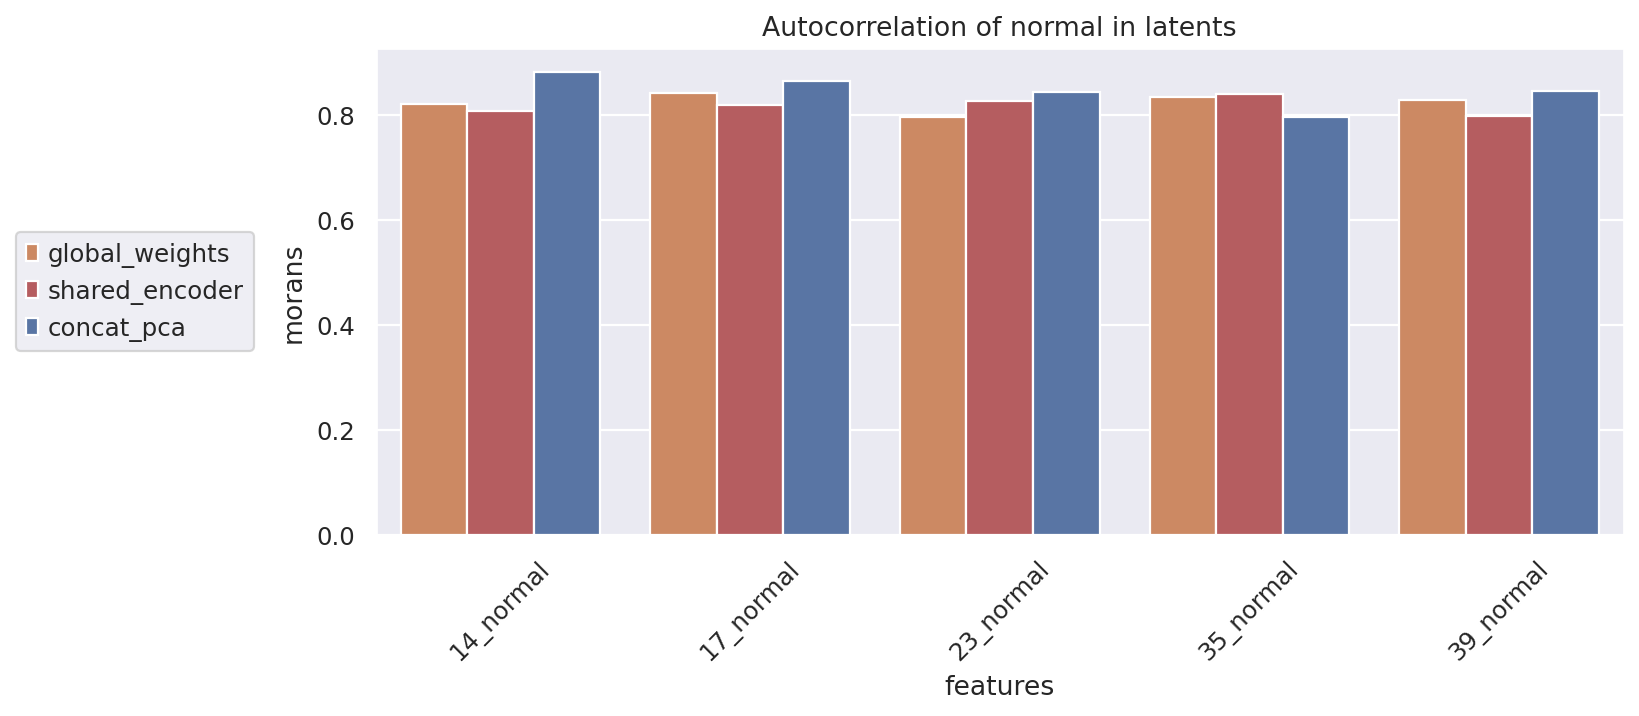

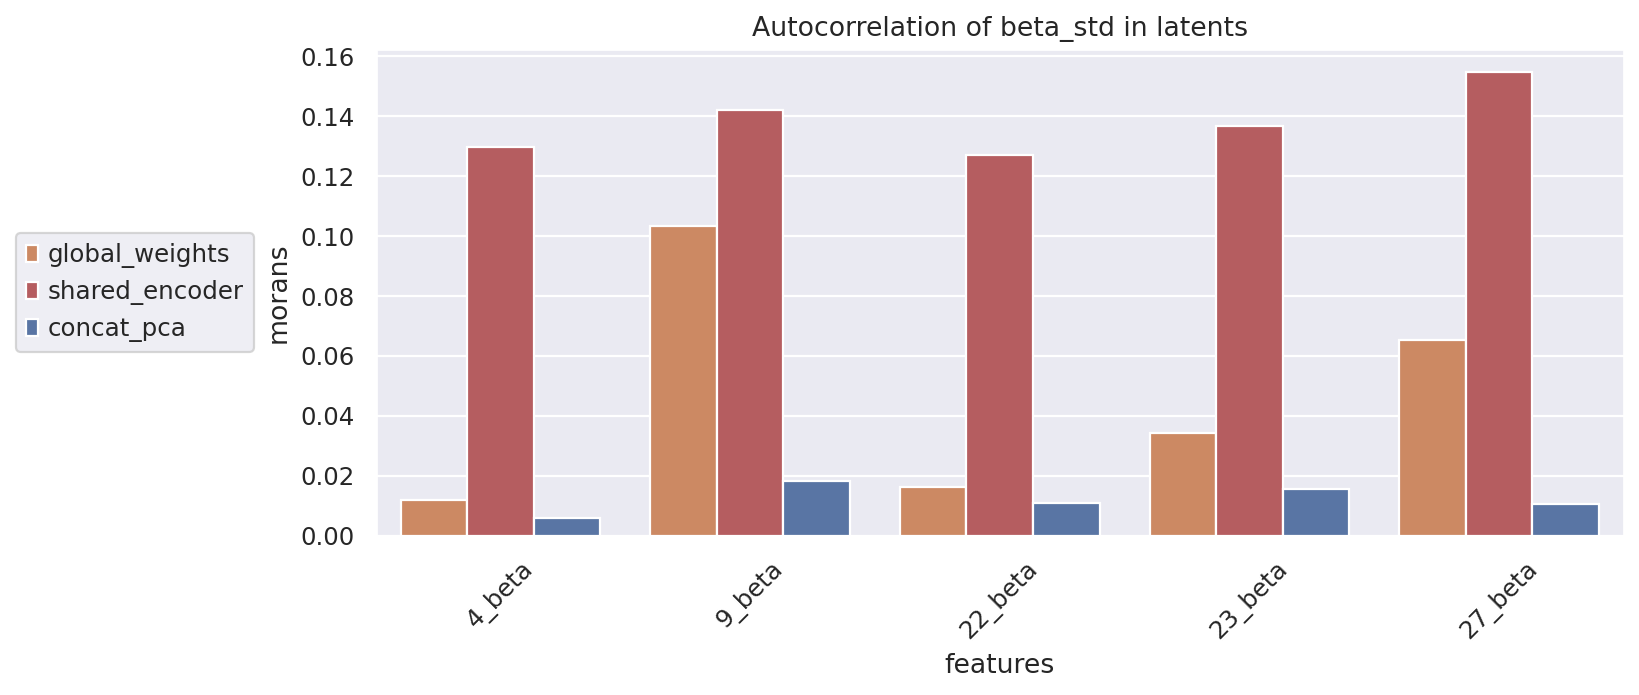

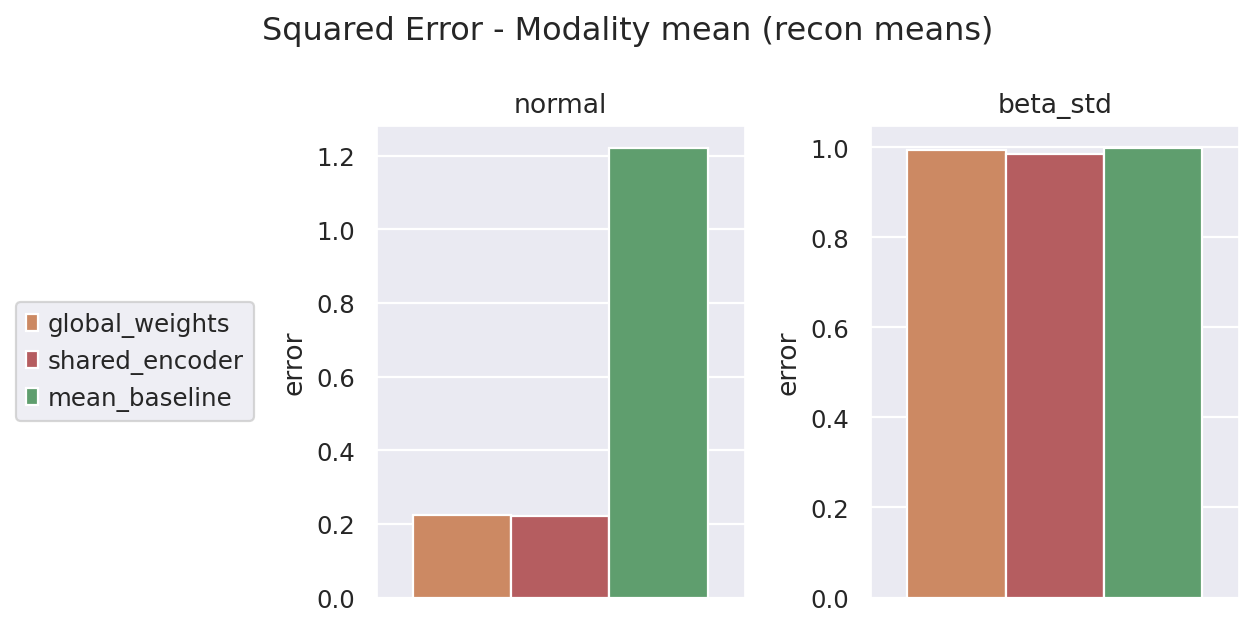

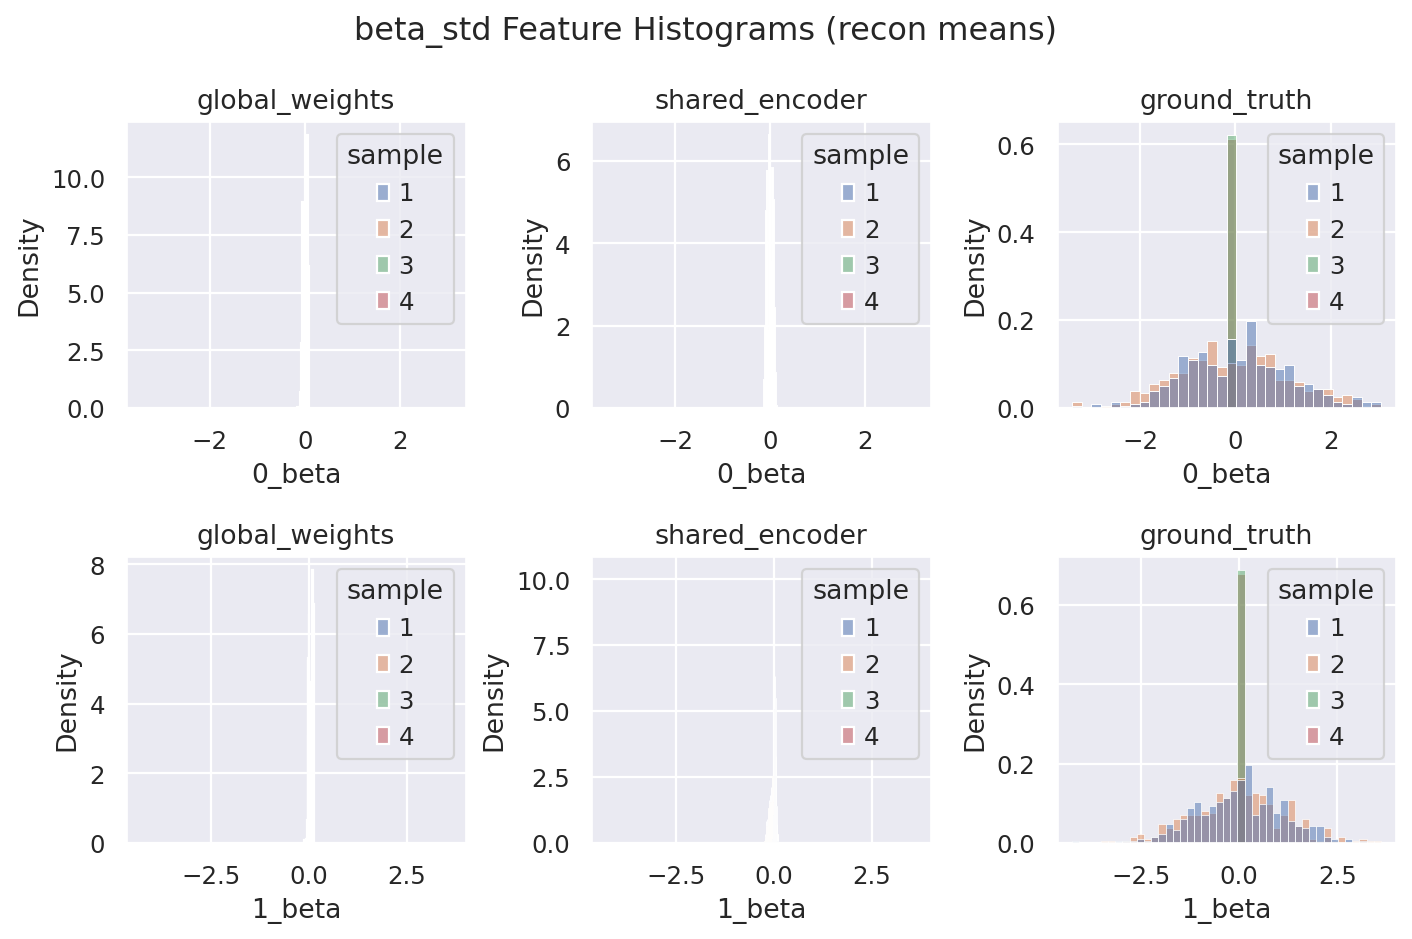

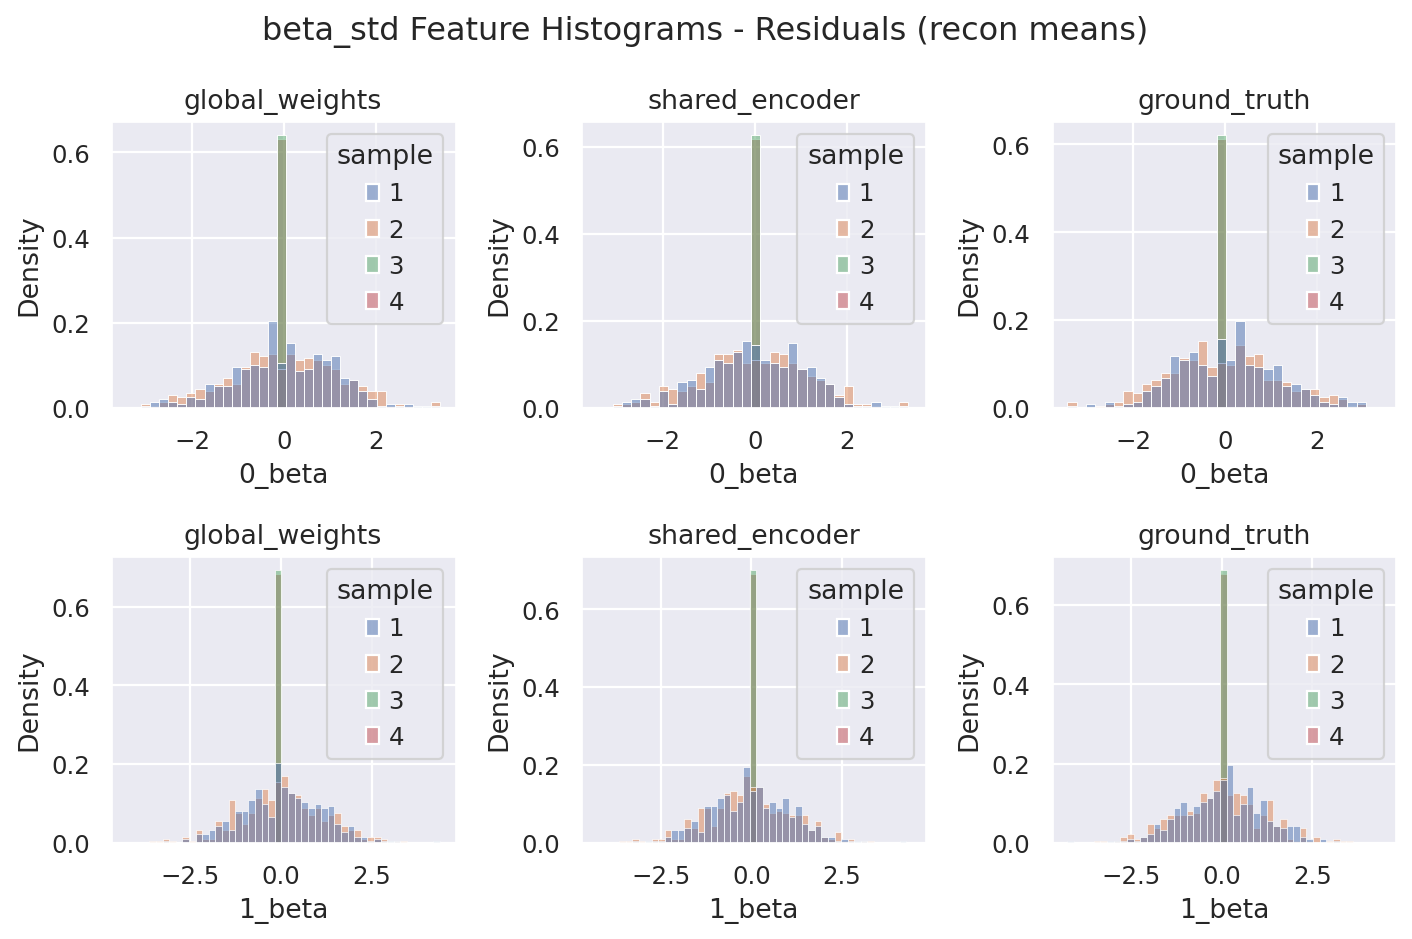

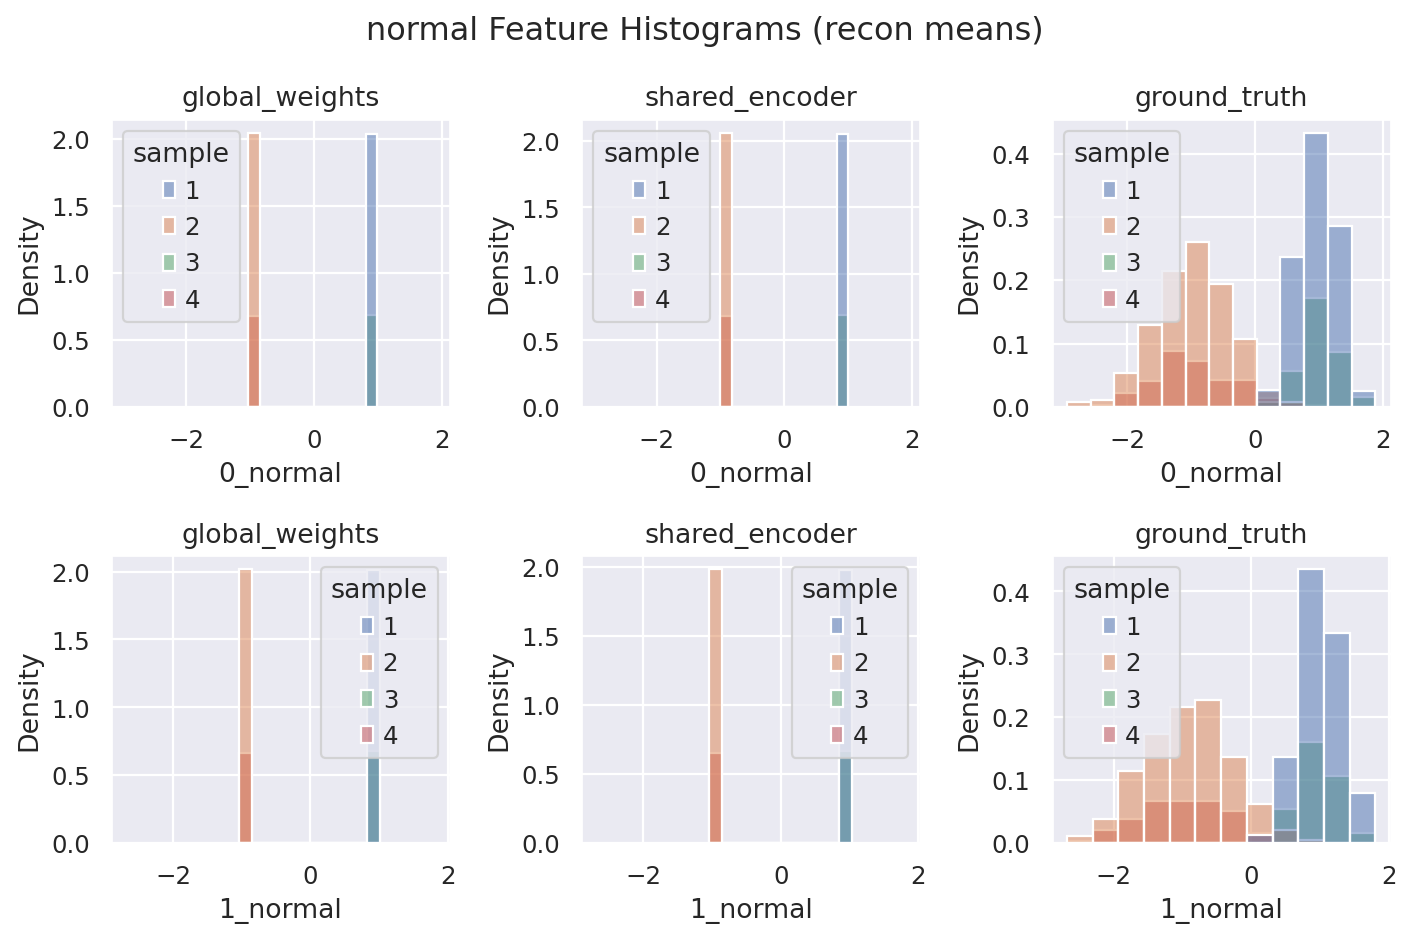

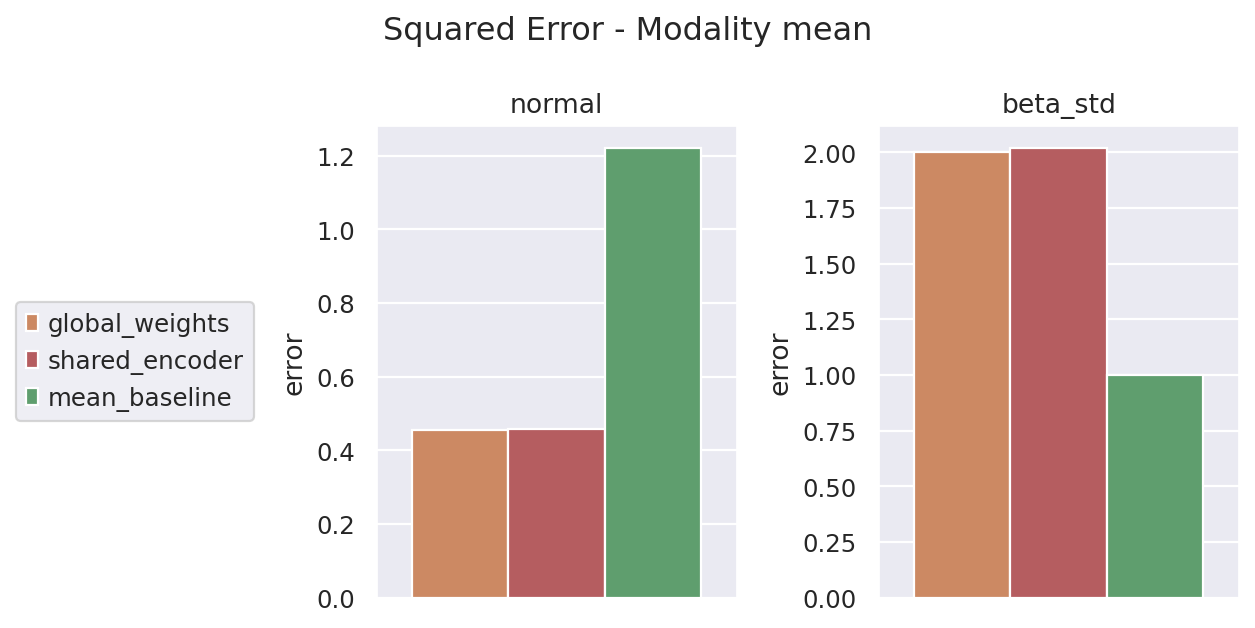

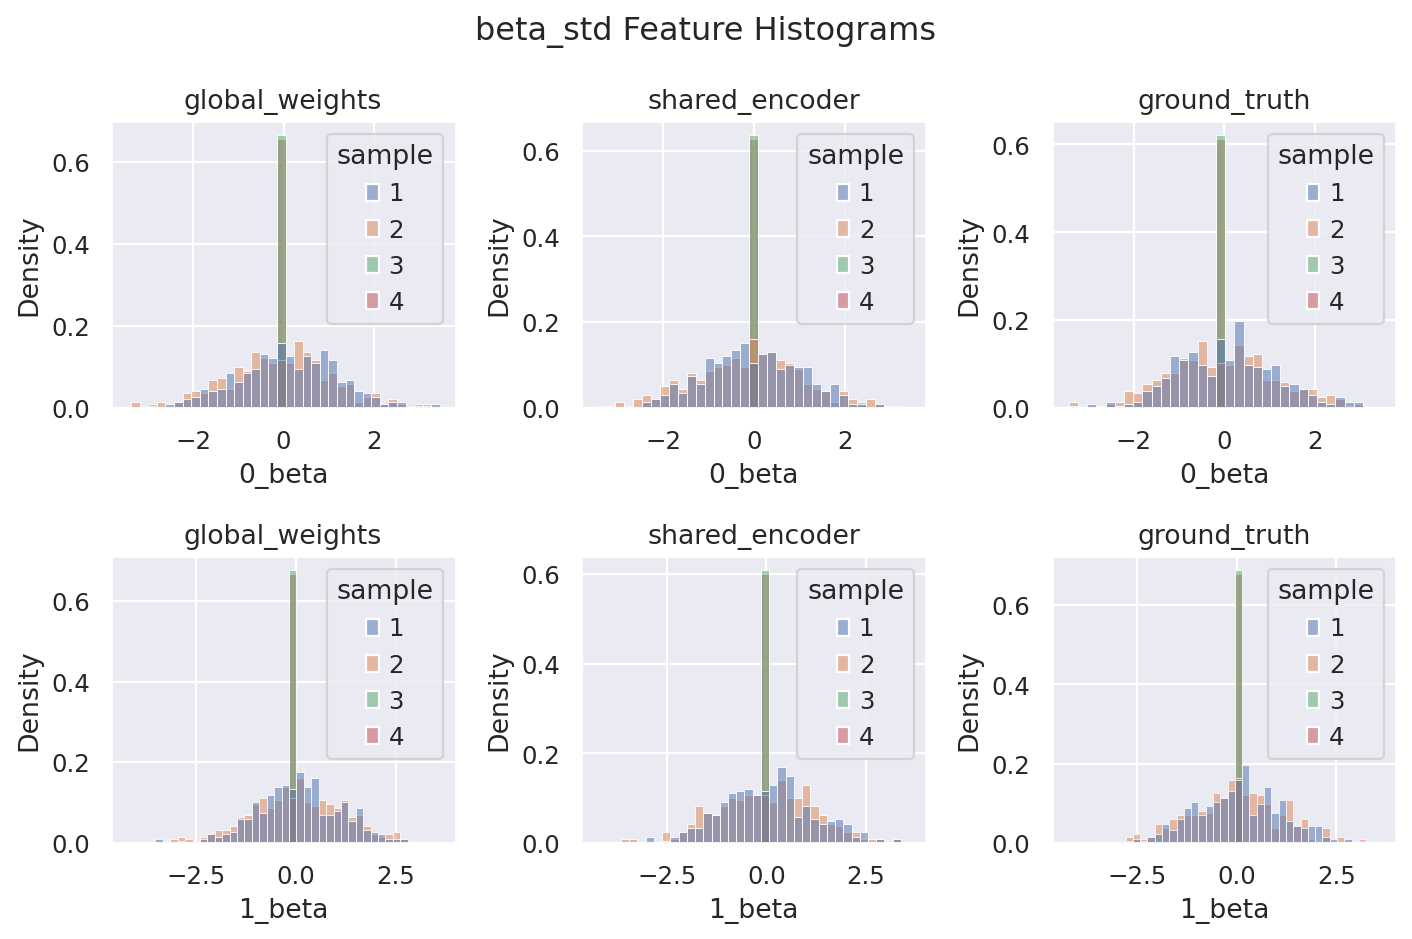

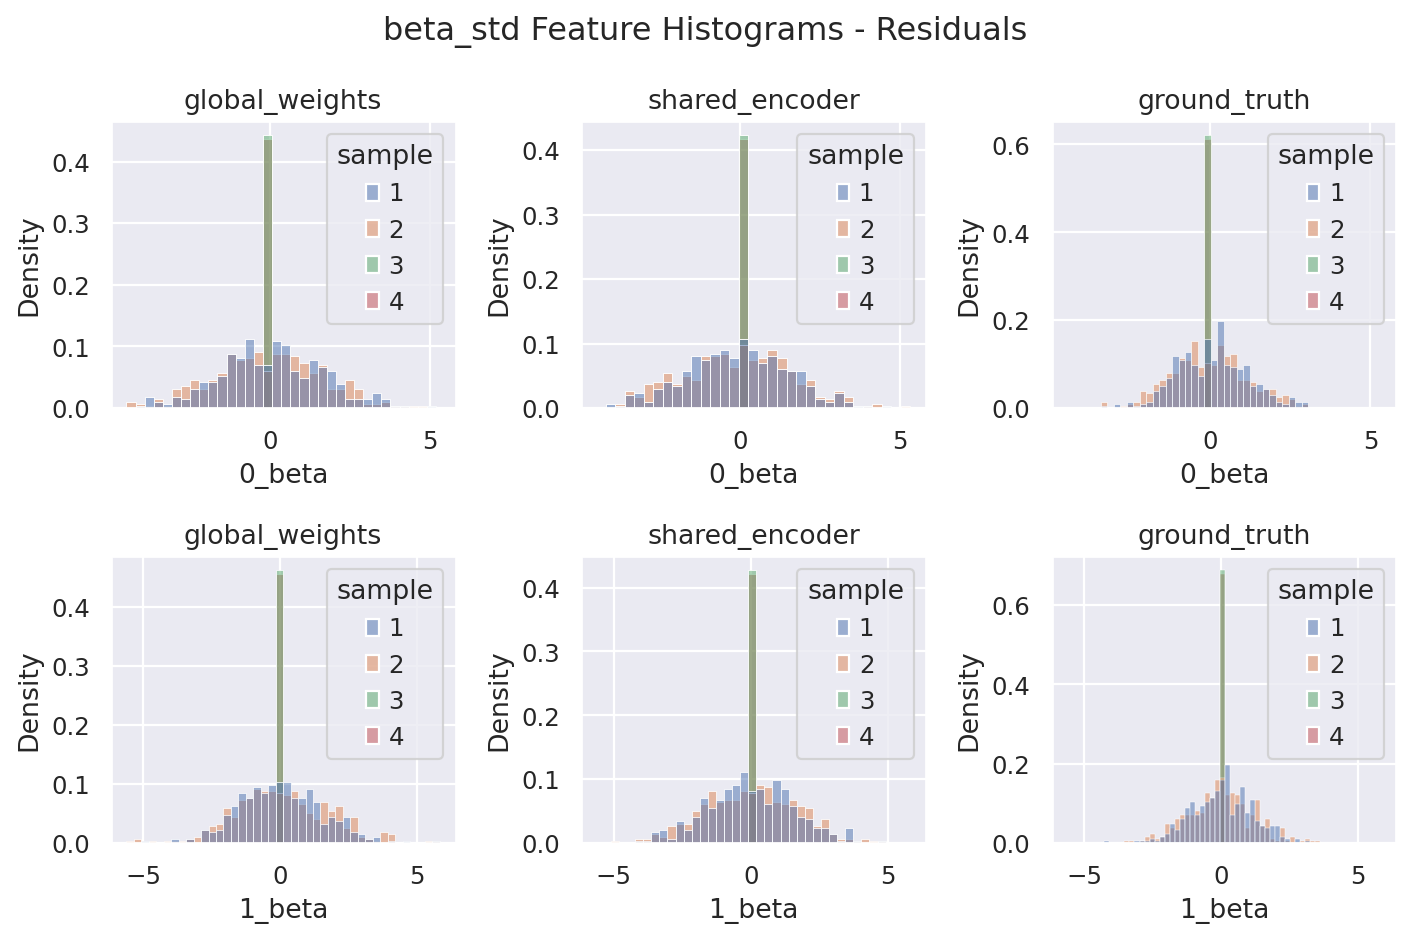

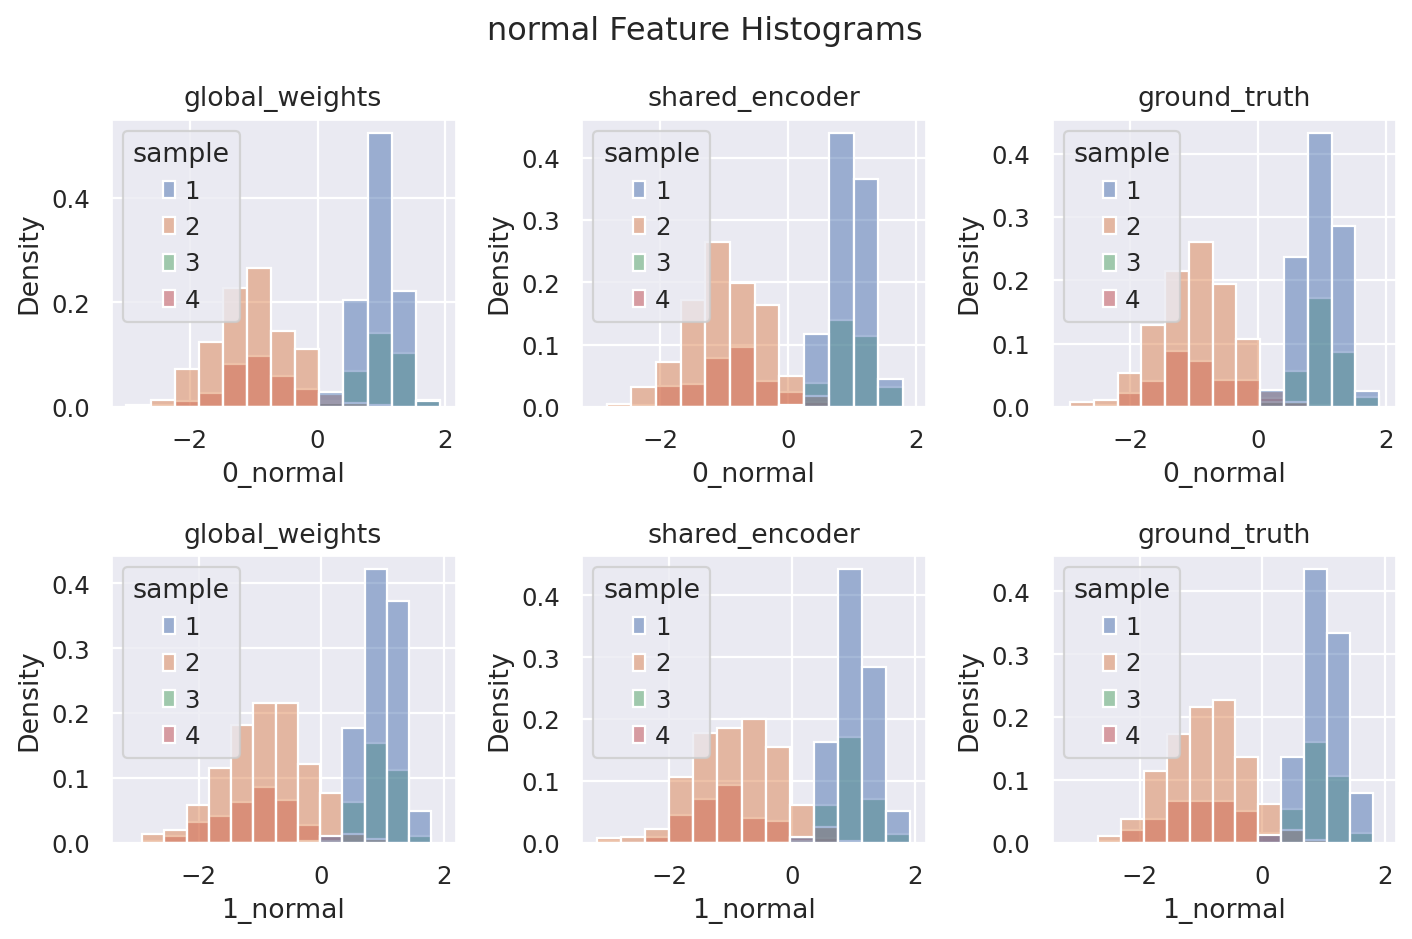

In [11]:
metrics = MultiModalVIMetrics(test_adata, pca_key='concat_pca', models={'global_weights': test_model, 'shared_encoder': test_shared_enc_model}, )
metrics.run()
metrics.autocorr_barplot('normal', auto_filter_features=5)
metrics.autocorr_barplot('beta_std', auto_filter_features=5)
for reconstruction_mean in (True, False):
    metrics.mean_modality_errors_barplot(reconstruction_mean=reconstruction_mean)
    metrics.feature_histplot(modality='beta_std', features=['0_beta', '1_beta'], hue='sample', reconstruction_mean=reconstruction_mean)
    metrics.feature_histplot(modality='beta_std', features=['0_beta', '1_beta'], hue='sample', residuals=True, reconstruction_mean=reconstruction_mean)
    _ = metrics.feature_histplot(modality='normal', features=['0_normal', '1_normal'], hue='sample', reconstruction_mean=reconstruction_mean)

### Model predicting beta distribution
Doesn't catch the drift

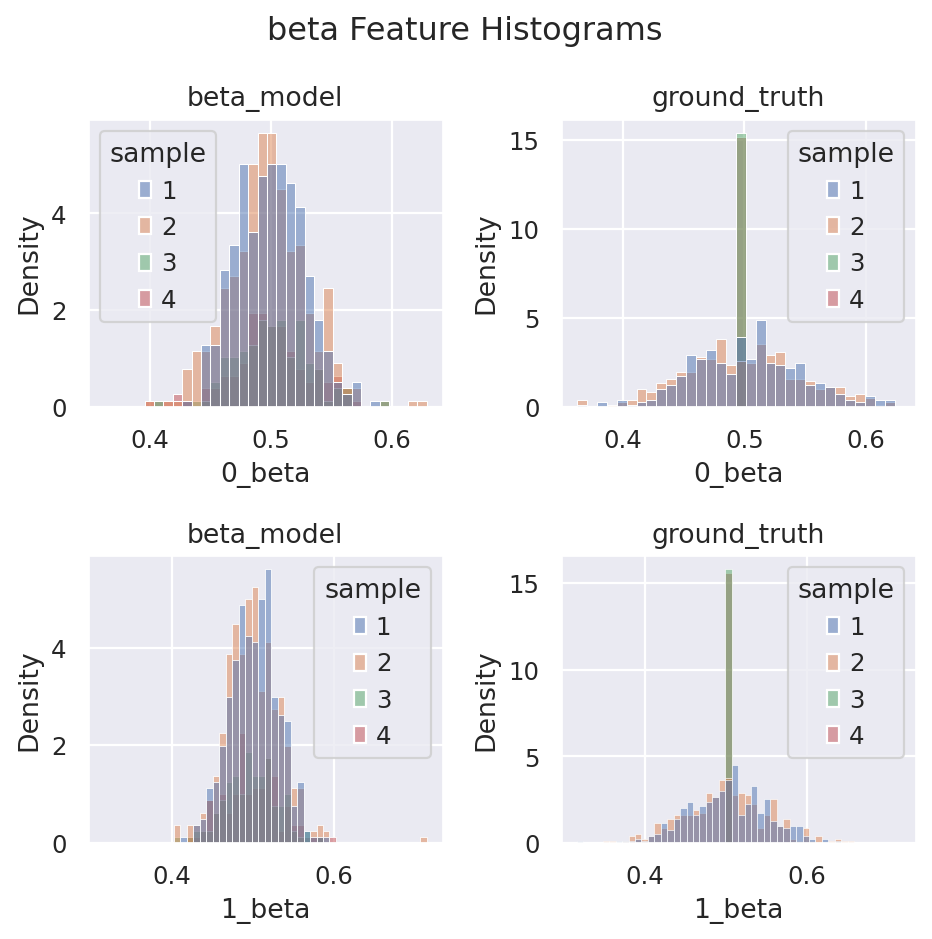

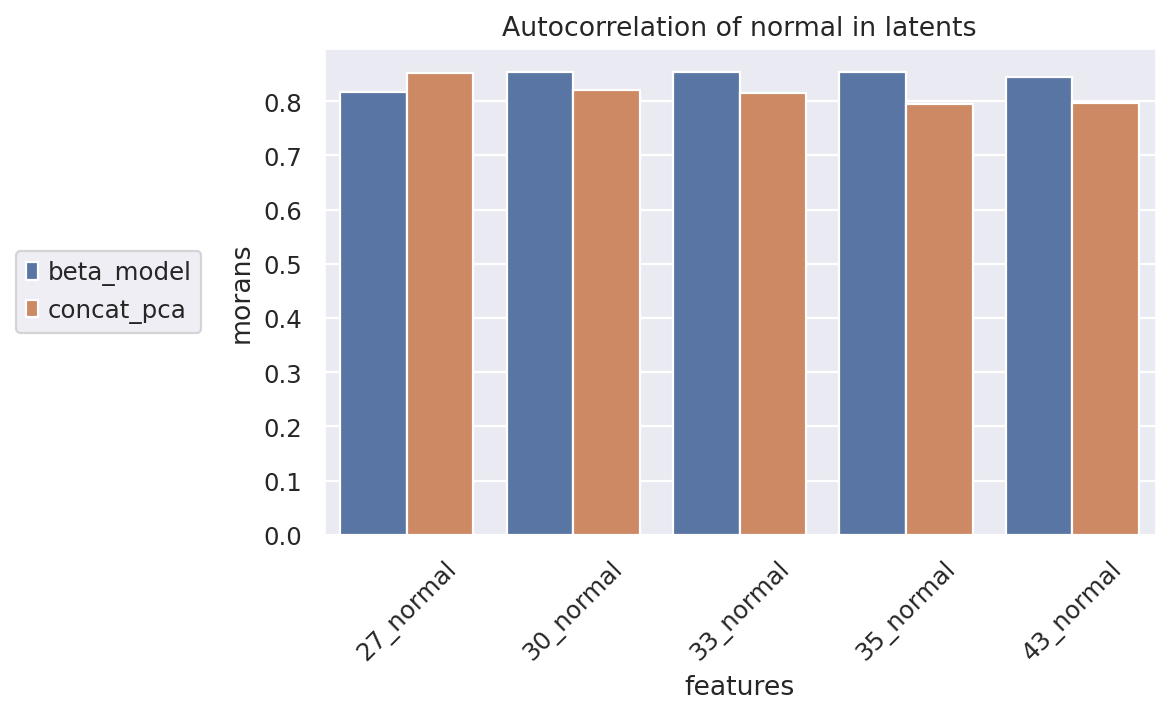

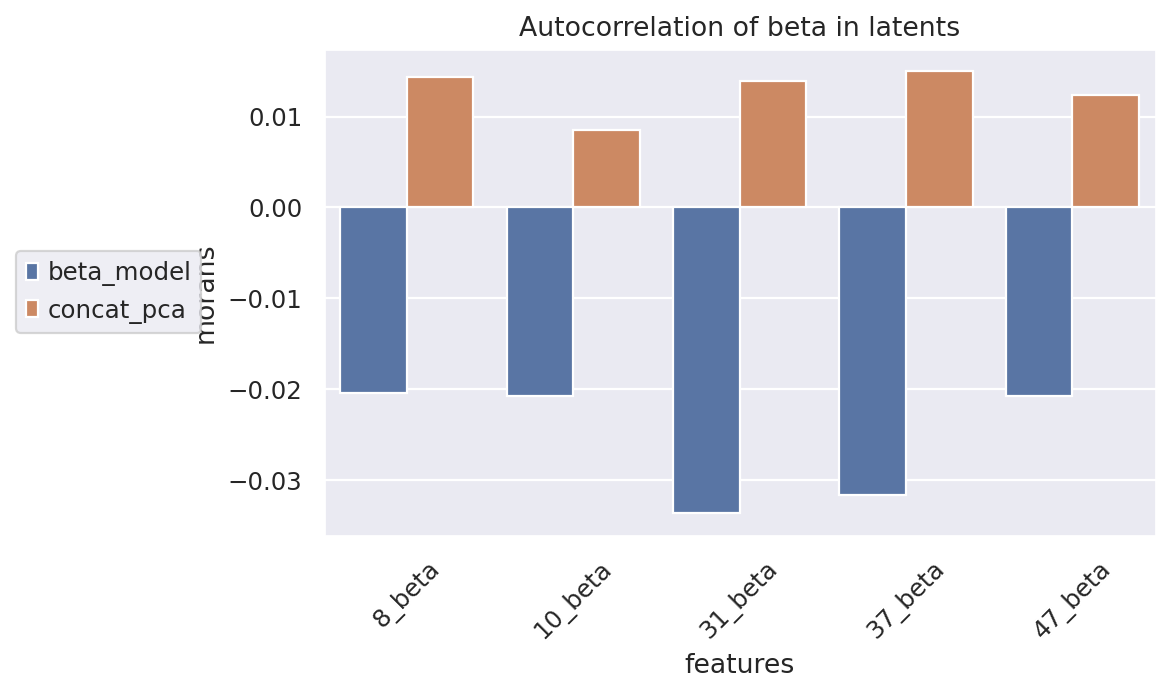

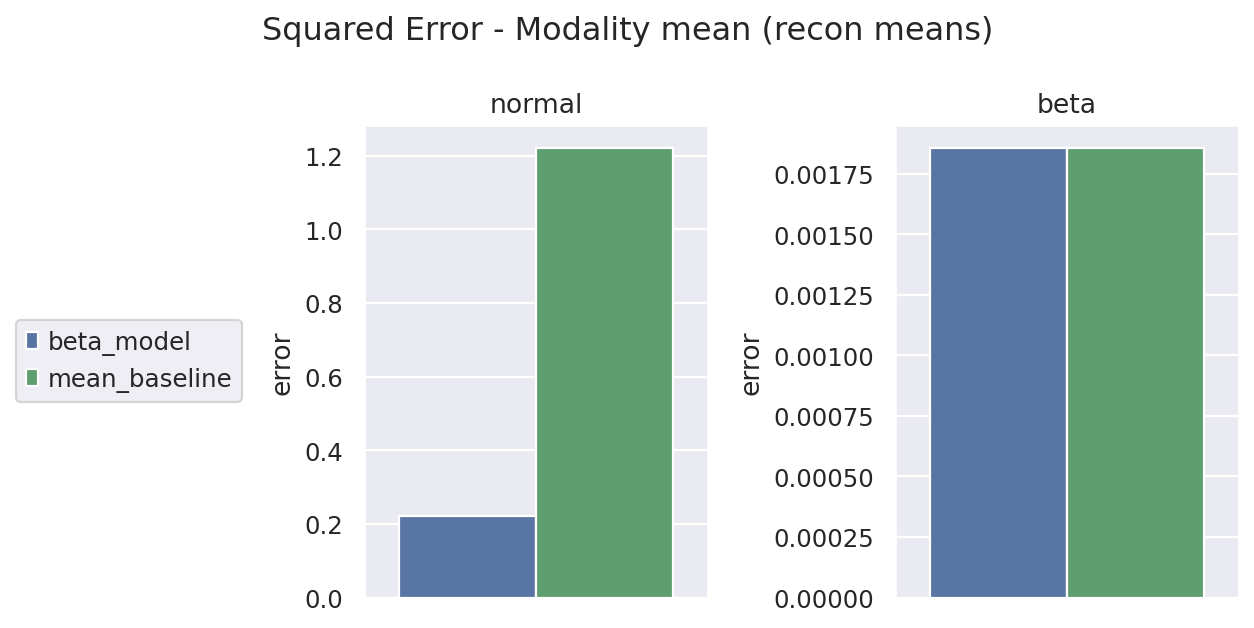

In [16]:
metrics = MultiModalVIMetrics(test_adata, pca_key='concat_pca', models={'beta_model': test_shared_enc_beta_model}, )
metrics.run()
metrics.feature_histplot(modality='beta', features=['0_beta', '1_beta'], hue='sample', reconstruction_mean=False)
metrics.autocorr_barplot('normal', auto_filter_features=5)
metrics.autocorr_barplot('beta', auto_filter_features=5)
_ = metrics.mean_modality_errors_barplot(reconstruction_mean=True)